# **Capstone project: Providing data-driven suggestions for Sailfort Motors**

# **Project Summary**

## Business Problem

Salifort Motors seeks to improve employee retention and answer the following question:
<br>
**What’s likely to make an employee leave the company?**

## Key Insights from Data Analysis

1. Two groups of employees tend to leave:

* **Underworked employees** – possibly dismissed due to low output.

* **Overworked employees** – likely resigned from burnout.

2. Employees with 7 projects all left the company.

3. Employees working 250+ hours per month showed extreme workloads and low satisfaction.

4. Employees who survive past year 6 rarely leave.

5. The optimal workload appears to be 3–4 projects per employee.

6. `Satisfaction level`, `number of projects`, `evaluation score`, and `time at company` are key predictors of turnover.

## Model Development and Evaluation 

Five models were trained and compared:

* **Logistic Regression** – High recall but many false positives.

* **Decision Tree (untuned)** – Overfitted the data.

* **Tuned Decision Tree** – Improved performance, reduced overfitting.

* **Random Forest** – Best generalization and stable performance.

* **XGBoost** – Highest accuracy but mild overfitting.

Across all datasets, **Random Forest** achieved the best balance between accuracy and generalization, followed closely by **XGBoost**.

## Recommendations

1. Limit the number of projects assigned per employee.

2. Investigate dissatisfaction among employees with ~4 years of tenure.

3. Reward or compensate long working hours, or reduce workload expectations.

4. Clarify company policies regarding overtime and workload.

5. Encourage open communication about workload and recognition.

6. Adjust evaluation criteria to avoid rewarding only overworked employees.

# **PACE stages**


## **Pace: Plan**

### Understanding the business scenario and problem

The case study has the following question: what’s likely to make the employee leave the company?

The goal of this project is to analyze the data and build a model that predicts whether or not an employee will leave the company.

If one can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention can be beneficial to a company.

### Familiarizing with the dataset

The dataset is available on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv). It contains 15,000 rows and 10 columns for the variables listed below. 

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Who are the stakeholders for this project?
 - Senior Leadership / Executive Team

### What am I trying to solve or accomplish?
 - Predict which employees are likely to leave and identify the most important, actionable factors driving turnover so HR and leadership can target interventions that improve retention and reduce hiring/training costs.

### Step 1. Imports

#### Importing packages

In [106]:
# EDA
import numpy as np
import pandas as pd

# Vizualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

# Tree Based Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Tuning the Tree Model
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

# Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

#### Loading dataset

In [107]:
df0 = pd.read_csv(r"E:\Data Analysis\Sailfort Motors\HR_comma_sep.csv")

df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

### Step 2. Data Exploration (Initial EDA and data cleaning)

#### Gathering basic information about the data

In [108]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


#### Gathering descriptive statistics about the data

In [109]:
df0.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

#### Renaming columns

Standardizing and correcting misspelled column names so that they are all in `snake_case`.

In [110]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [111]:
df0 = df0.rename(columns = {
    'average_montly_hours': 'average_monthly_hours',
    'Work_accident': 'work_accident',
    'Department': 'department'})

df0.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

#### Checking for missing values

In [112]:
df0.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

#### Checking for duplicates

In [113]:
df0.duplicated().sum()

np.int64(3008)

In [114]:
df0[df0.duplicated()].head()

satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  time_spend_company  work_accident  left  \
396                     139                   3              0     1   
866                     128                   3              0     1   
1317                    127                   3              0     1   
1368                    132                   3              0     1   
1461                    142                   3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

In [115]:
df1 = df0.drop_duplicates(keep = 'first')

df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

#### Checking for outliers

<function matplotlib.pyplot.show(close=None, block=None)>

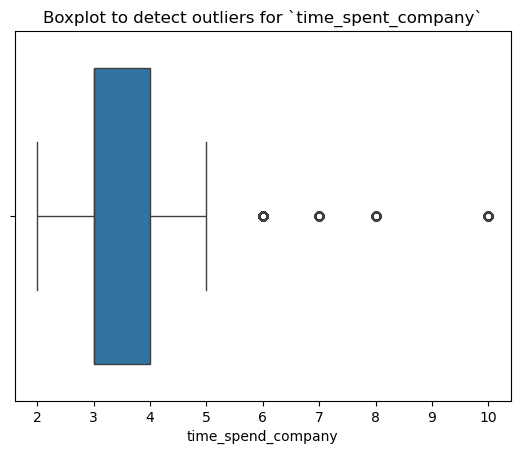

In [116]:
sns.boxplot(x = df1['time_spend_company'])
plt.title('Boxplot to detect outliers for `time_spent_company`', fontsize=12)
plt.show

The boxplot above shows that there are outliers in the `time_spent_company` variable.

In [117]:
# Determine the number of rows containing outliers

Q1 = df1['time_spend_company'].quantile(0.25)
Q3 = df1['time_spend_company'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df1[(df1['time_spend_company'] < lower_limit) | (df1['time_spend_company'] > upper_limit)]

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)
print("Number of rows in the data containing outliers in `time_spend_company`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `time_spend_company`: 824


Certain types of models are more sensitive to outliers than others (e.g. Logistic Regression comapred to Tree Based models).

## **pAce: Analyze Stage**
Performing EDA (analyzing relationships between variables)



### Step 2. Data Exploration (Continuing EDA)

Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [118]:
# Get numbers of people who left vs. stayed
left_count = (df1['left'] == 1).sum()
stayed_count = (df1['left'] == 0).sum()

# Get percentages of people who left vs. stayed
left_perc = (df1['left'] == 1).sum() / (df1['left'].count())
stayed_perc = (df1['left'] == 0).sum() / (df1['left'].count())

print("Count of poeple who left:", left_count)
print("Count of poeple who stayed:", stayed_count)

print("% of poeple who left, {:.2f}%".format(left_perc * 100))
print("% of poeple who stayed, {:.2f}%".format(stayed_perc * 100))

Count of poeple who left: 1991
Count of poeple who stayed: 10000
% of poeple who left, 16.60%
% of poeple who stayed, 83.40%


#### Data visualizations

<Axes: title={'center': 'Number of projects histogram'}, xlabel='number_project', ylabel='Count'>

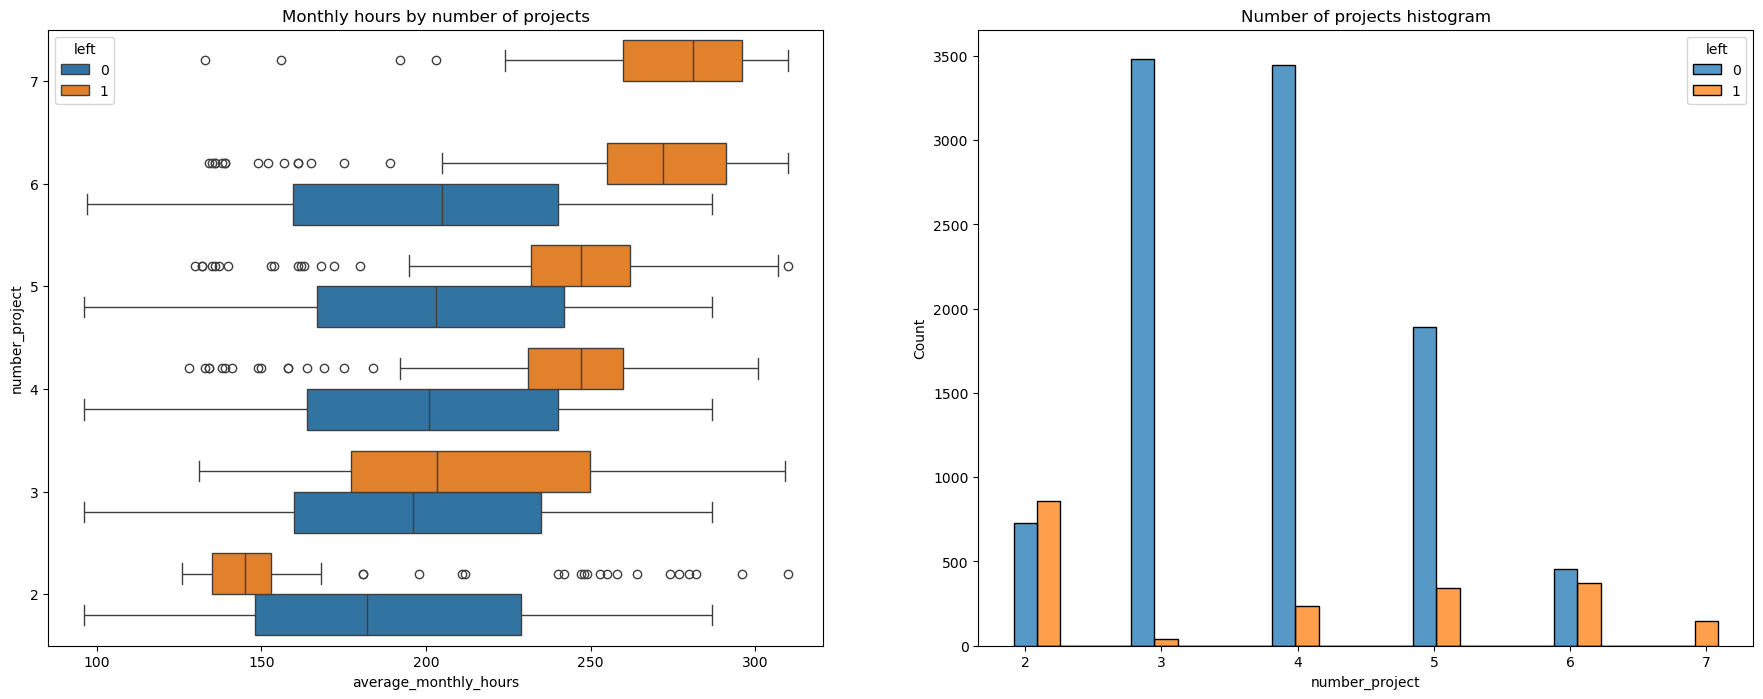

In [119]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

ax[0].set_title('Monthly hours by number of projects')
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax = ax[0]).invert_yaxis()

ax[1].set_title('Number of projects histogram')
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax = ax[1])

As expected the more projects people work on, the longer the hours they spend, however:
* There is a pattern of two groups leaving the company - those who worked less their coworkers with the same project load, and those who worked much more compared to the rest. For group A we could infer that they might have been fired. Group B however seems more reasonable to infer that they quit.
* The optimal number of projects seem to be 3 and 4, they are with smaller ratio of left/stayed comapred to the rest, also with the least outliers.
* Everyone with 7 projects left the company.
* With the increase of number of projects those who left start to **average between 250 and 300 monthly hours** at work, much more compared to the rest. If we assume a work week of 40 hours (5 days a week, 8 hours per day), then the average number of working hours per month should be `50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that almost every group, even those who didn't leave the company, worked considerably more hours than this. The employees here seem quite overworked.


In [120]:
df1[df1['number_project'] == 7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

This confirms that indeed every employee with 7 projects did leave. 

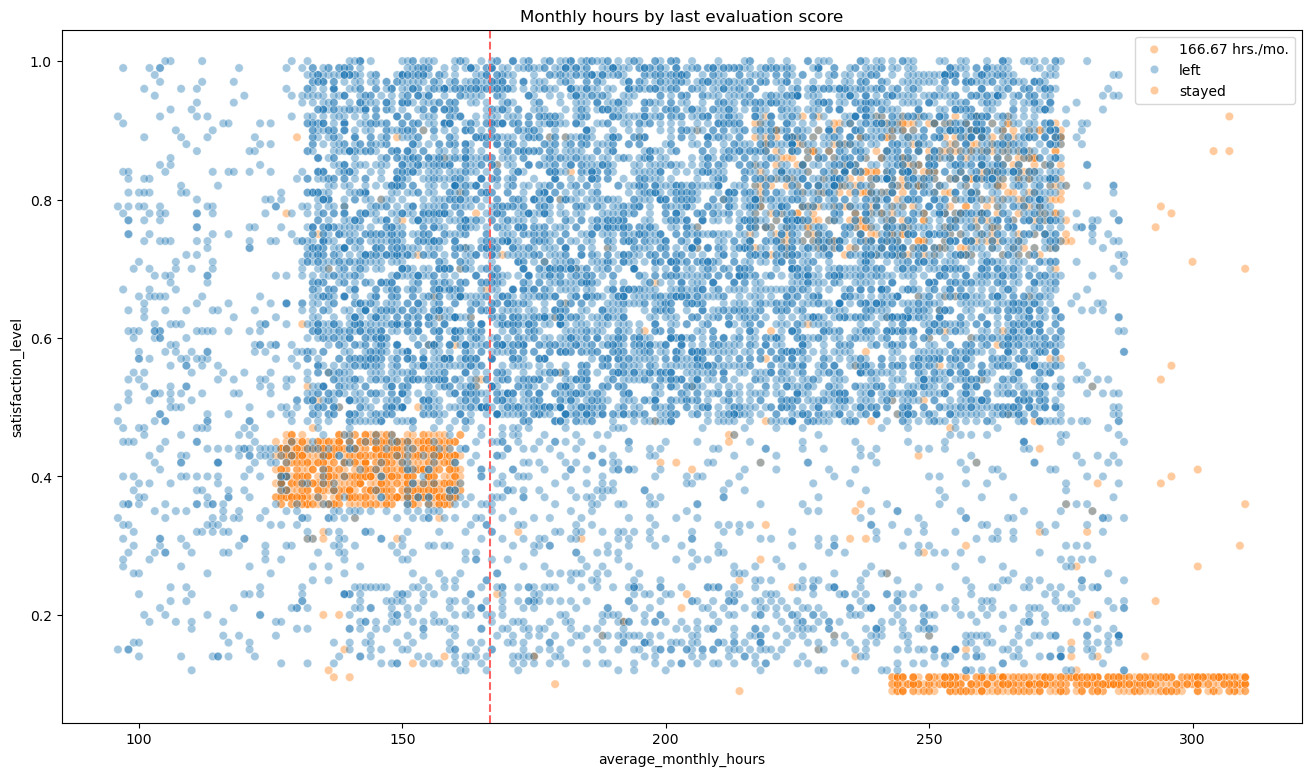

In [121]:
plt.figure(figsize=(16, 9))

plt.title('Monthly hours by last evaluation score')

sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)

plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')

plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])

The scatterplot futher confirmes our theory of overworked emlpoyees. It is likely related to their satisfaction levels being close to 0. The plot also shows the other group that left - the ones that were not overworked also had lower satisfaction levels comapred to the rest. Between those two There is a 3rd group that left with higher satisfactions levels. 

The shapes in the plot seems strage, they are tightly packed with clean lines, and almost no spill over, it could be a sign of data manipulation or syntetic data. 

Text(0.5, 1.0, 'Time_spent_company histogram')

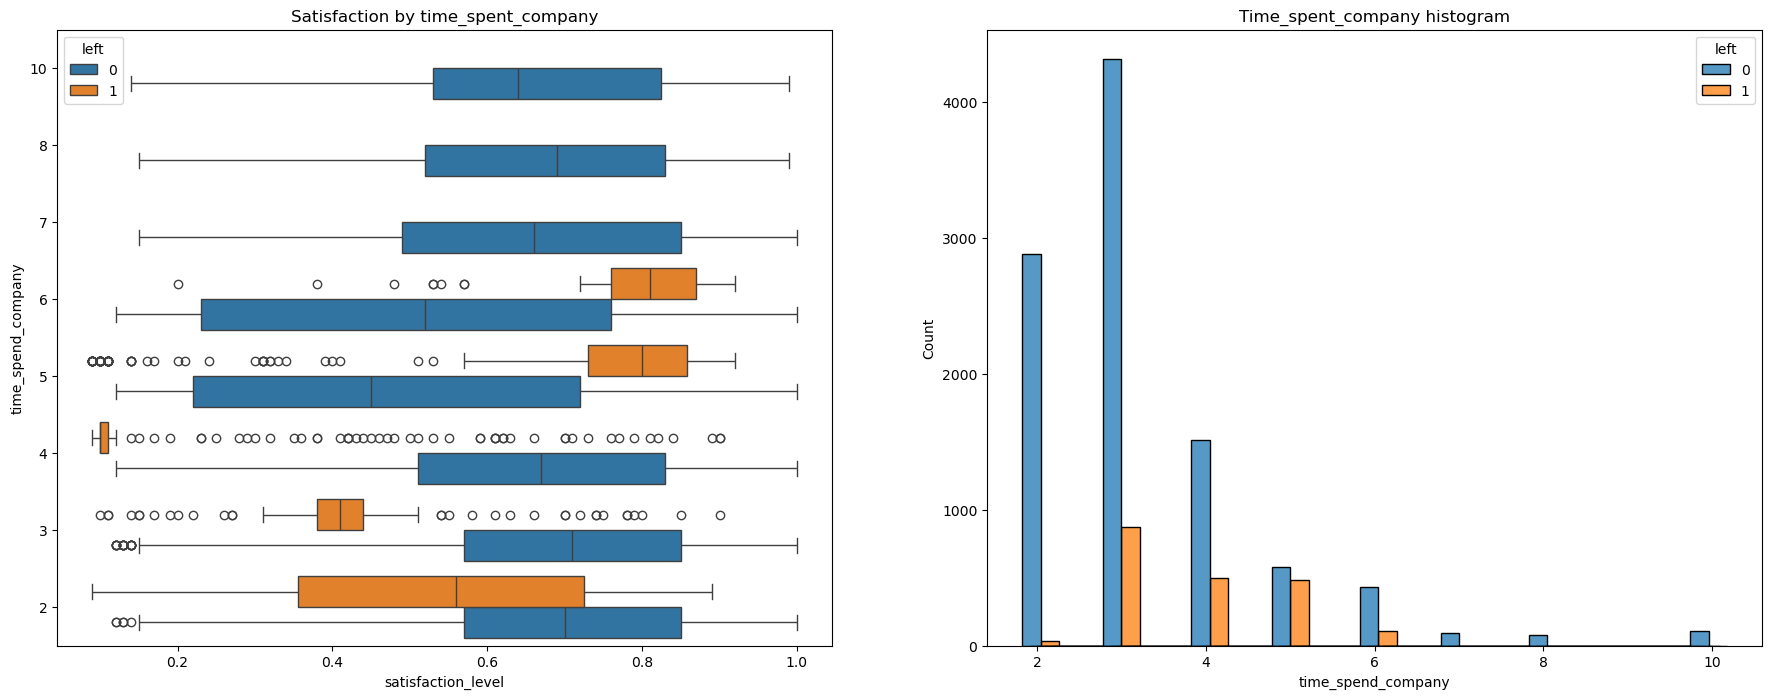

In [122]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df1, x='satisfaction_level', y='time_spend_company', hue='left', orient="h", ax = ax[0]).invert_yaxis()
ax[0].set_title('Satisfaction by time_spent_company')

sns.histplot(data=df1, x='time_spend_company', hue='left', multiple='dodge', shrink=5, ax = ax[1])
ax[1].set_title('Time_spent_company histogram')

These plots indicate that:
* The emlpoyees' satisfaction increase with the more time spent in the company.
* The long tenured emloyees are much less comapred to the rest.
* After the 6th year there are no leavers.
* The 4th year leavers have an extremely low satisfaction, something might've happened there. 

In [123]:
df1.groupby('left')['satisfaction_level'].agg(['mean', 'median']).round(2)

mean  median
left              
0     0.67    0.69
1     0.44    0.41

As expected the ones who left did in fact had lower mean and meadian compared to the ones that stayed. The satisfcation of the ones that stayed is skewed to the left (mean < median)

In [124]:
# Defining short-tenured employees
tenure_short = df1[df1['time_spend_company'] < 7]

# Defining long-tenured employees
tenure_long = df1[df1['time_spend_company'] > 6]

Text(0.5, 1.0, 'Salary hisotgram by tenure: long tenured emloyees')

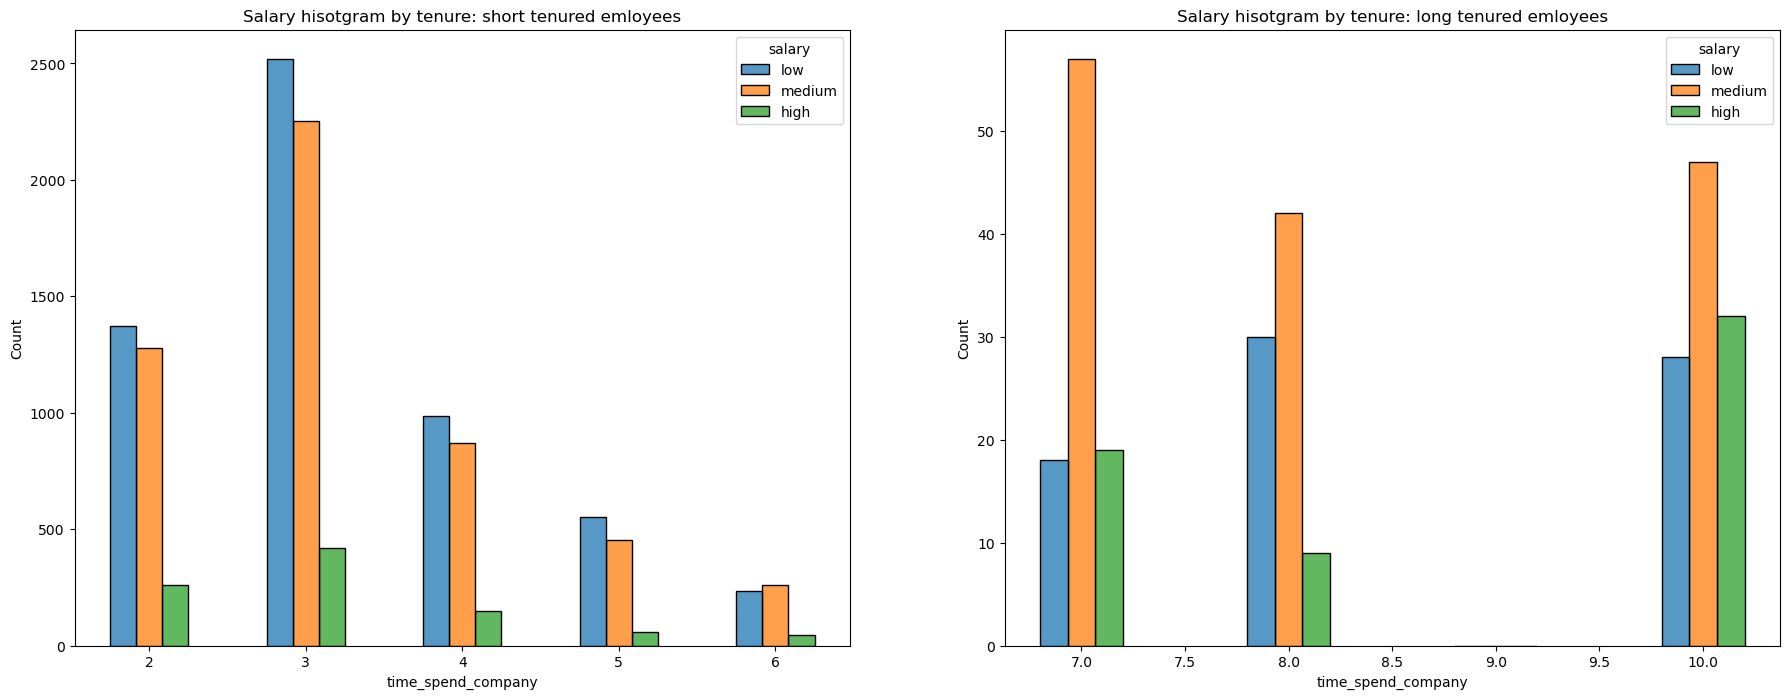

In [125]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.histplot(data=tenure_short, x='time_spend_company', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax = ax[0])
ax[0].set_title('Salary hisotgram by tenure: short tenured emloyees')

sns.histplot(data=tenure_long, x='time_spend_company', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax = ax[1])
ax[1].set_title('Salary hisotgram by tenure: long tenured emloyees')

The plots indicate that long term emloyees were not disproportionately comprised of higher-paid employees.

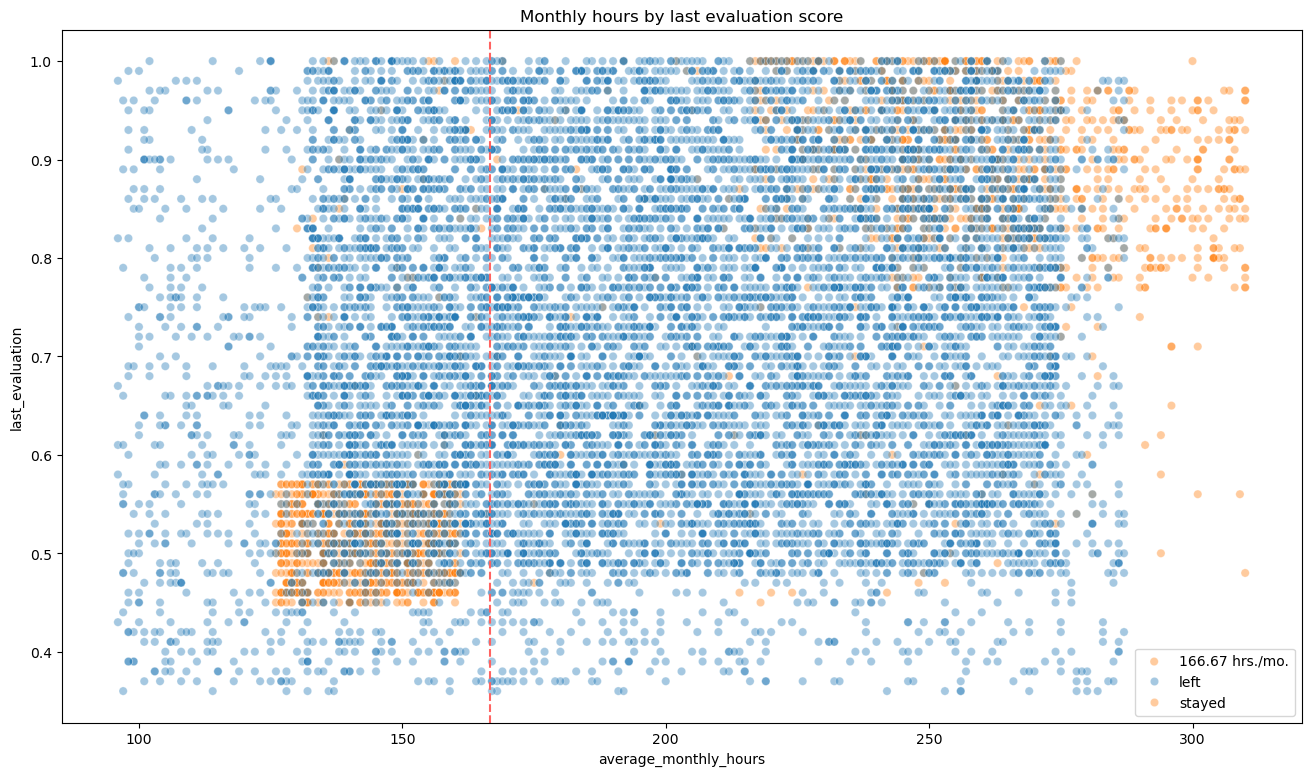

In [126]:
plt.figure(figsize=(16, 9))

plt.title('Monthly hours by last evaluation score')

sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)

plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')

plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])

The scatterplot again shows the 2 groups of leavers - the overworked ones and the underworked ones. The overworked ones were evalutated quite well, however those who worked under the red line were evaluated with a lower score. This further suggests that the second group might have been fired. It also sets a corelaton between hours worked and evaluation score.

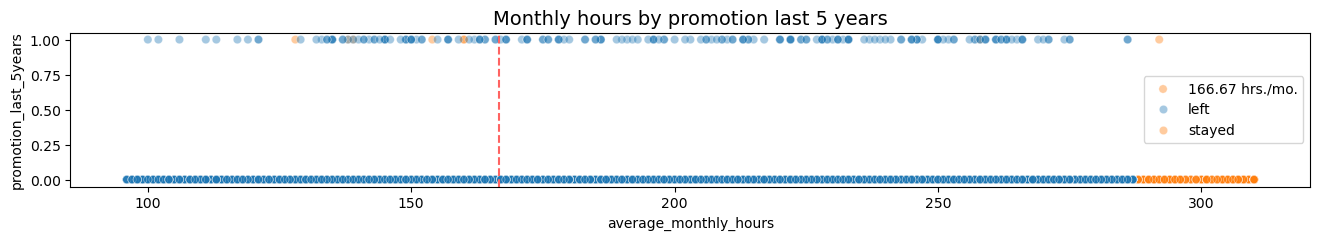

In [127]:
plt.figure(figsize=(16, 2))

plt.title('Monthly hours by promotion last 5 years', fontsize='14');

sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)

plt.axvline(x=166.67, color='#ff6361', ls='--')

plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])

The plot shows that: 
* Very few people promoted in the last 5 years left.
* Working long hours does not guarantee promotion.

In [128]:
df1["department"].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

<Axes: title={'center': 'Counts of Stayed/Left by department'}, xlabel='department', ylabel='Count'>

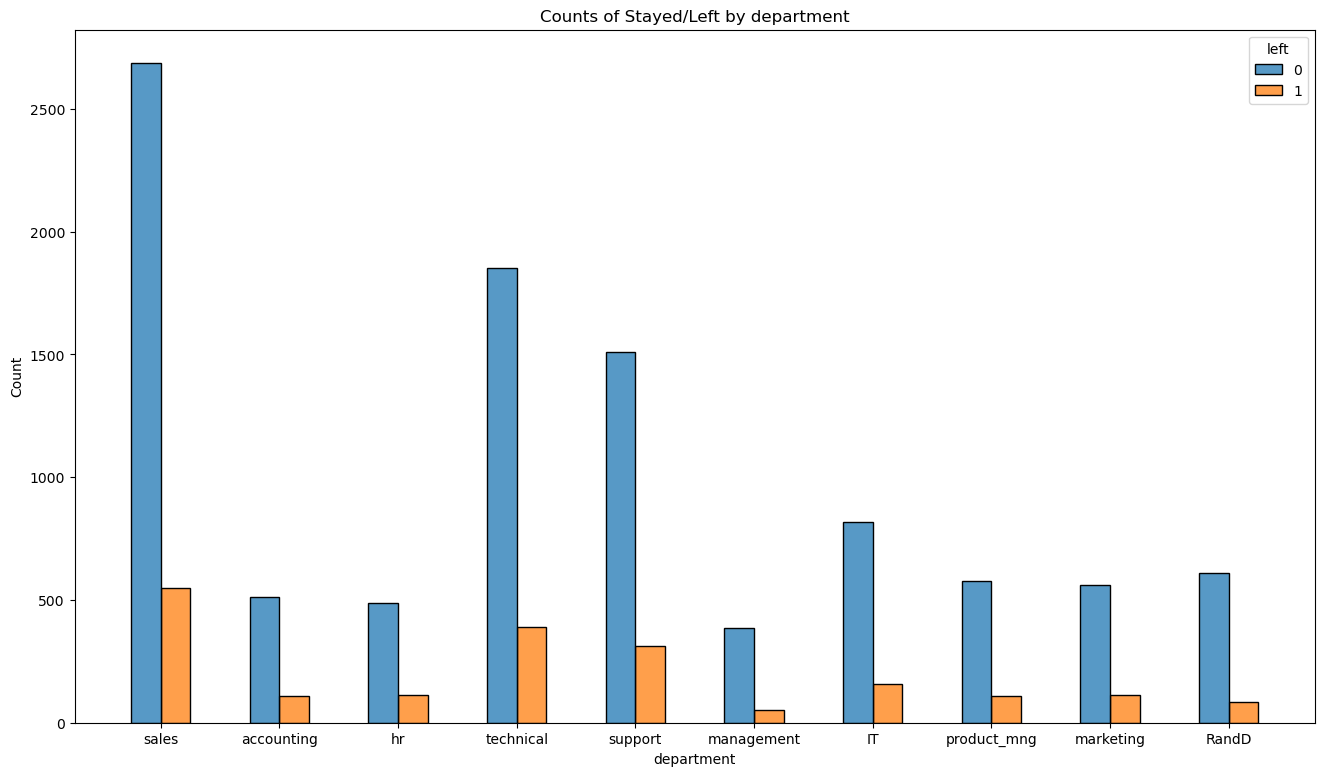

In [129]:
plt.figure(figsize=(16, 9))
plt.title('Counts of Stayed/Left by department')
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)

By department findings seem irrelevant.

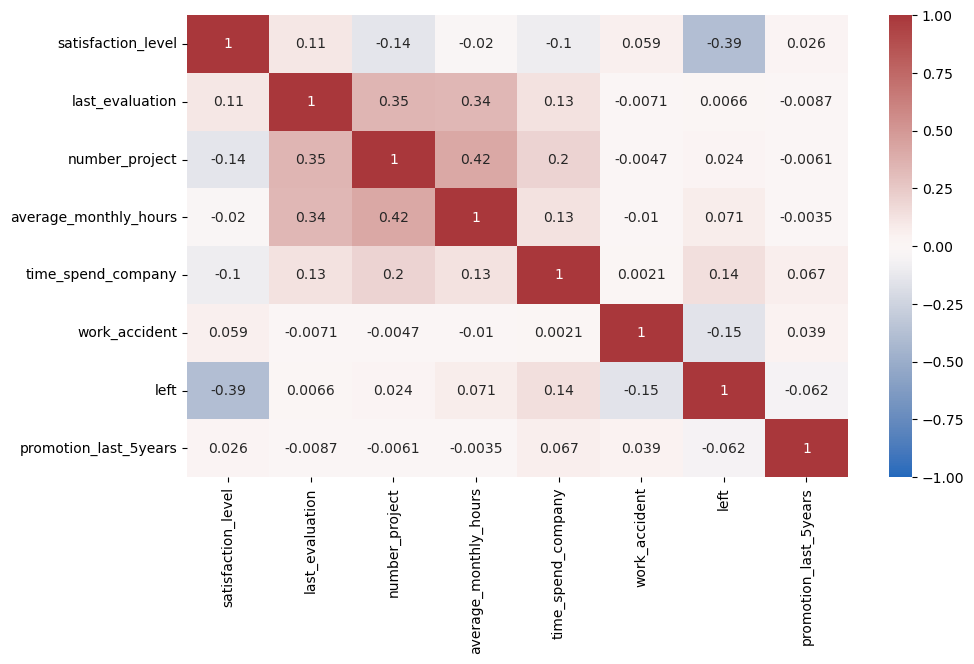

In [130]:
plt.figure(figsize=(10.66, 6))
heatmap = sns.heatmap(
    df0.select_dtypes(include=['number']).corr(),
    vmin=-1, vmax=1,
    annot=True,
    cmap=sns.color_palette("vlag", as_cmap=True)
)
plt.show()

The heatmaps confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

### Insights

* Substantial part of the employees are overworked with lots of projects and long working hours.
* Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels.
* There is a corellation between hours worked and high evaluation score.
* If an employee survives till the 6th year they tend to stay.

## **paCe: Construct Stage**
- Determining which models are most appropriate
- Constructing the models
- Evaluating model results to determine how well your model fits the data

### Recalling model assumptions

**Linear Regression model assumptions**
- Outcome variable is continuous (numeric).
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Homoscedasticity

**Hypothesis Testing model assumptions** 
- Test claims or differences between groups (e.g., means, proportions, correlations)
- Observations are independent of each other
- Equal variances (homogeneity)
- Random sampling

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

**Tree Based Model assumptions**
- Can handle both numeric and categorical features.
- No assumptions about data distribution (non-parametric).
- No need for linearity between X and y.
- No need for normality of variables.
- Insensitive to multicollinearity.
- Can handle outliers fairly well.


### Step 3. Model Building
- Fitting a model that predicts the outcome variable using two or more independent variables
- Checking model assumptions
- Evaluating the model

#### Identifying the types of models most appropriate for this task.

 - Logistic Regression and Tree Based Models

### Data Preperation

##### Limited features (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`)

In [200]:
df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [201]:
df1_limited = df1.drop(['department', 'salary', 'work_accident', 'promotion_last_5years'], axis = 1)
df1_limited.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  left  
0                   3     1  
1                   6     1  
2                   4     1  
3                   5     1  
4                   3     1

##### Full (encoded) features (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [202]:
df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [203]:
df1_encoded = df1.copy()
df1_encoded.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [204]:
df1_encoded['salary'] = (
    df1_encoded['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)
df1_encoded.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0       0  
1       1  
2       1  
3       0  
4       0

In [205]:
df1_encoded = pd.get_dummies(df1_encoded, drop_first = False)
df1_encoded.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years  salary  \
0                   3              0     1                      0       0   
1                   6              0     1                      0       1   
2                   4              0     1                      0       1   
3                   5              0     1                      0       0   
4                   3              0     1                      0       0   

   department_IT  department_RandD  department_accounting  department_hr  \
0          False             False                  False          False   
1          False             False                  False          False   
2          False             False                  False          False   
3          False             False                  False          False   
4          False             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

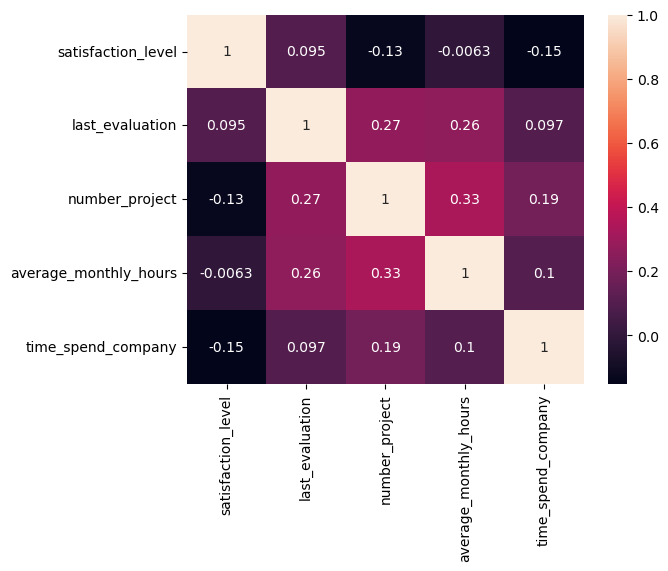

In [206]:
sns.heatmap(
    df1_encoded[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']]
.corr(), annot = True)
plt.show()

##### Overworked (`last_evaluation`, `number_project`, `overworked` (`average_monthly_hours`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [207]:
df1_overworked = df1_encoded.drop('satisfaction_level', axis = 1)
df1_overworked.head()

last_evaluation  number_project  average_monthly_hours  time_spend_company  \
0             0.53               2                    157                   3   
1             0.86               5                    262                   6   
2             0.88               7                    272                   4   
3             0.87               5                    223                   5   
4             0.52               2                    159                   3   

   work_accident  left  promotion_last_5years  salary  department_IT  \
0              0     1                      0       0          False   
1              0     1                      0       1          False   
2              0     1                      0       1          False   
3              0     1                      0       0          False   
4              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [208]:
df1_overworked['overworked'] = df1_overworked['average_monthly_hours']

print('Max hours:', df1_overworked['overworked'].max())
print('Min hours:', df1_overworked['overworked'].min())

Max hours: 310
Min hours: 96


In [209]:
df1_overworked['overworked'] = (df1_overworked['overworked'] > 175).astype(int)

In [210]:
df1_overworked = df1_overworked.drop('average_monthly_hours', axis = 1)
df1_overworked.head()

last_evaluation  number_project  time_spend_company  work_accident  left  \
0             0.53               2                   3              0     1   
1             0.86               5                   6              0     1   
2             0.88               7                   4              0     1   
3             0.87               5                   5              0     1   
4             0.52               2                   3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0          False             False   
1                      0       1          False             False   
2                      0       1          False             False   
3                      0       0          False             False   
4                      0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
1                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
1                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   

   department_support  department_technical  overworked  
0               False                 False           0  
1               False                 False           1  
2               False                 False           1  
3               False                 False           1  
4               False                 False           0

### Modeling

#### Logistic Regression

##### Limited (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`)

In [211]:
## Removing outliers for logistic regression

df1_limited_inlier = df1_limited[(df1_limited['time_spend_company'] >= lower_limit) &
                 (df1_limited['time_spend_company'] <= upper_limit)]

df1_limited_inlier.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   time_spend_company  left  
0                   3     1  
2                   4     1  
3                   5     1  
4                   3     1  
5                   3     1

In [212]:
X_lr1 = df1_limited_inlier.drop('left', axis = 1)
y_lr1 = df1_limited_inlier['left']

In [213]:
X_lr1_train, X_lr1_test, y_lr1_train, y_lr1_test = train_test_split(X_lr1, y_lr1, test_size = 0.25, stratify = y_lr1, random_state = 0)

In [214]:
log_reg1 = LogisticRegression(class_weight='balanced', random_state = 0).fit(X_lr1_train, y_lr1_train)

In [215]:
y_pred_logreg1 = log_reg1.predict(X_lr1_test)

y_pred_logreg1_proba = log_reg1.predict_proba(X_lr1_test)[:, 1]

In [216]:
print("Accuracy:", "%.3f" % metrics.accuracy_score(y_lr1_test, y_pred_logreg1))
print("Precision:", "%.3f" % metrics.precision_score(y_lr1_test, y_pred_logreg1))
print("Recall:", "%.3f" % metrics.recall_score(y_lr1_test, y_pred_logreg1))
print("F1 Score:", "%.3f" % metrics.f1_score(y_lr1_test, y_pred_logreg1))
print("AUC:", "%.3f" % metrics.roc_auc_score(y_lr1_test, y_pred_logreg1_proba))

Accuracy: 0.831
Precision: 0.499
Recall: 0.924
F1 Score: 0.648
AUC: 0.884


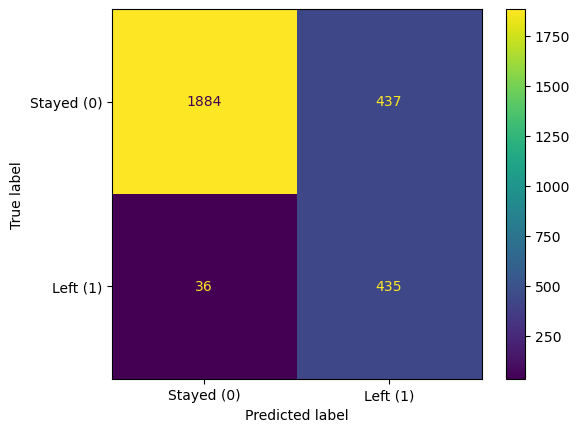

In [217]:
cm_lr1 = metrics.confusion_matrix(y_lr1_test, y_pred_logreg1, labels = [0, 1])
disp_lr1 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_lr1, display_labels = ['Stayed (0)', 'Left (1)'])
disp_lr1.plot(values_format='')

##### Full (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [218]:
## Removing outliers for logistic regression

df1_encoded_inlier = df1_encoded[(df1_encoded['time_spend_company'] >= lower_limit) &
                 (df1_encoded['time_spend_company'] <= upper_limit)]

df1_encoded_inlier.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   time_spend_company  work_accident  left  promotion_last_5years  salary  \
0                   3              0     1                      0       0   
2                   4              0     1                      0       1   
3                   5              0     1                      0       0   
4                   3              0     1                      0       0   
5                   3              0     1                      0       0   

   department_IT  department_RandD  department_accounting  department_hr  \
0          False             False                  False          False   
2          False             False                  False          False   
3          False             False                  False          False   
4          False             False                  False          False   
5          False             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

In [219]:
X_lr2 = df1_encoded_inlier.drop('left', axis = 1)
y_lr2 = df1_encoded_inlier['left']

In [220]:
X_lr2_train, X_lr2_test, y_lr2_train, y_lr2_test = train_test_split(X_lr2, y_lr2, test_size = 0.25, stratify = y_lr2, random_state = 0)

In [221]:
log_reg2 = LogisticRegression(class_weight='balanced', random_state = 0, max_iter=500).fit(X_lr2_train, y_lr2_train)

In [222]:
y_pred_logreg2 = log_reg2.predict(X_lr2_test)

y_pred_logreg2_proba = log_reg2.predict_proba(X_lr2_test)[:, 1]

In [223]:
print("Accuracy:", "%.3f" % metrics.accuracy_score(y_lr2_test, y_pred_logreg2))
print("Precision:", "%.3f" % metrics.precision_score(y_lr2_test, y_pred_logreg2))
print("Recall:", "%.3f" % metrics.recall_score(y_lr2_test, y_pred_logreg2))
print("F1 Score:", "%.3f" % metrics.f1_score(y_lr2_test, y_pred_logreg2))
print("AUC:", "%.3f" % metrics.roc_auc_score(y_lr2_test, y_pred_logreg2_proba))

Accuracy: 0.838
Precision: 0.511
Recall: 0.913
F1 Score: 0.655
AUC: 0.894


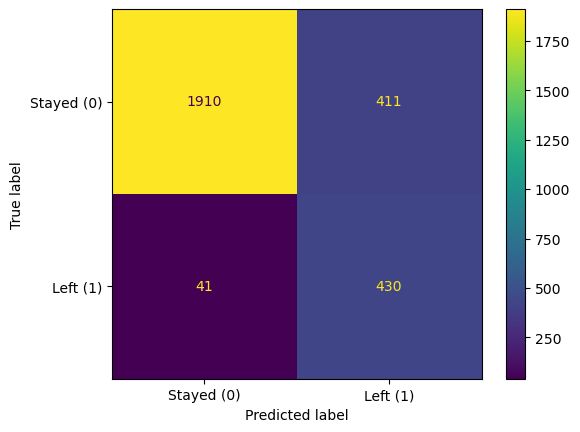

In [224]:
cm_lr2 = metrics.confusion_matrix(y_lr2_test, y_pred_logreg2, labels = [0, 1])
disp_lr2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_lr2, display_labels = ['Stayed (0)', 'Left (1)'])
disp_lr2.plot(values_format='')

##### Overworked (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` (`overworked`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [225]:
## Removing outliers for logistic regression

df1_overworked_inlier = df1_overworked[(df1_overworked['time_spend_company'] >= lower_limit) &
                 (df1_overworked['time_spend_company'] <= upper_limit)]

df1_overworked_inlier.head()

last_evaluation  number_project  time_spend_company  work_accident  left  \
0             0.53               2                   3              0     1   
2             0.88               7                   4              0     1   
3             0.87               5                   5              0     1   
4             0.52               2                   3              0     1   
5             0.50               2                   3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0          False             False   
2                      0       1          False             False   
3                      0       0          False             False   
4                      0       0          False             False   
5                      0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   
5                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   
5                 False                   False              True   

   department_support  department_technical  overworked  
0               False                 False           0  
2               False                 False           1  
3               False                 False           1  
4               False                 False           0  
5               False                 False           0

In [226]:
X_lr3 = df1_overworked_inlier.drop('left', axis = 1)
y_lr3 = df1_overworked_inlier['left']

In [227]:
X_lr3_train, X_lr3_test, y_lr3_train, y_lr3_test = train_test_split(X_lr3, y_lr3, test_size = 0.25, stratify = y_lr3, random_state = 0)

In [228]:
log_reg3 = LogisticRegression(class_weight='balanced', random_state = 0).fit(X_lr3_train, y_lr3_train)

In [229]:
y_pred_logreg3 = log_reg3.predict(X_lr3_test)

y_pred_logreg3_proba = log_reg3.predict_proba(X_lr3_test)[:, 1]

In [230]:
print("Accuracy:", "%.3f" % metrics.accuracy_score(y_lr3_test, y_pred_logreg3))
print("Precision:", "%.3f" % metrics.precision_score(y_lr3_test, y_pred_logreg3))
print("Recall:", "%.3f" % metrics.recall_score(y_lr3_test, y_pred_logreg3))
print("F1 Score:", "%.3f" % metrics.f1_score(y_lr3_test, y_pred_logreg3))
print("AUC:", "%.3f" % metrics.roc_auc_score(y_lr3_test, y_pred_logreg3_proba))

Accuracy: 0.736
Precision: 0.377
Recall: 0.866
F1 Score: 0.525
AUC: 0.816


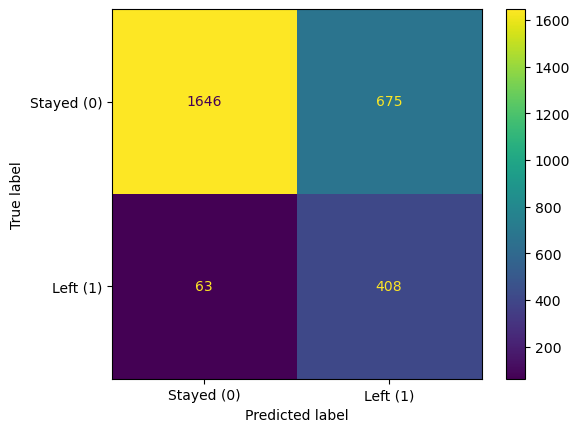

In [231]:
cm_lr3 = metrics.confusion_matrix(y_lr3_test, y_pred_logreg3, labels = [0, 1])
disp_lr3 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_lr3, display_labels = ['Stayed (0)', 'Left (1)'])
disp_lr3.plot(values_format='')

#### Tree Based

##### Limited (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`)

In [232]:
X_dt1 = df1_limited.drop('left', axis = 1)
y_dt1 = df1_limited['left']

In [233]:
X_dt1_train, X_dt1_test, y_dt1_train, y_dt1_test = train_test_split(X_dt1, y_dt1, test_size = 0.25, stratify = y_dt1, random_state = 0)

In [234]:
decision_tree1 = DecisionTreeClassifier(random_state = 0).fit(X_dt1_train, y_dt1_train)

In [235]:
y_pred_dt1 = decision_tree1.predict(X_dt1_test)

y_pred_dt1_proba = decision_tree1.predict_proba(X_dt1_test)[:, 1]

In [243]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt1_test, y_pred_dt1))
print("Precision:", "%.3f" % precision_score(y_dt1_test, y_pred_dt1))
print("Recall:", "%.3f" % recall_score(y_dt1_test, y_pred_dt1))
print("F1 Score:", "%.3f" % f1_score(y_dt1_test, y_pred_dt1))
print("AUC:", "%.3f" % roc_auc_score(y_dt1_test, y_pred_dt1_proba))

Accuracy: 0.969
Precision: 0.898
Recall: 0.918
F1 Score: 0.908
AUC: 0.948


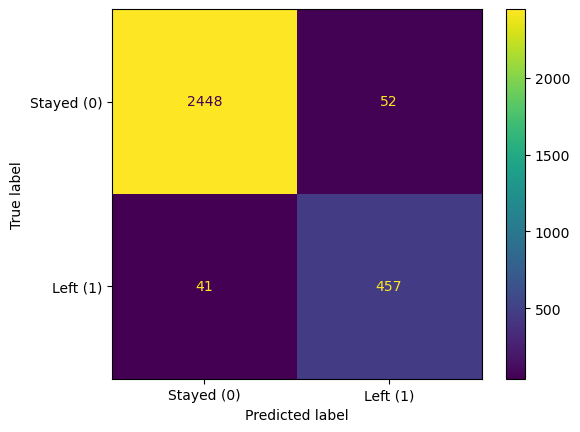

In [244]:
cm_dt1 = metrics.confusion_matrix(y_dt1_test, y_pred_dt1, labels = decision_tree1.classes_)
disp_dt1 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_dt1, display_labels = ['Stayed (0)', 'Left (1)'])
disp_dt1.plot(values_format='')

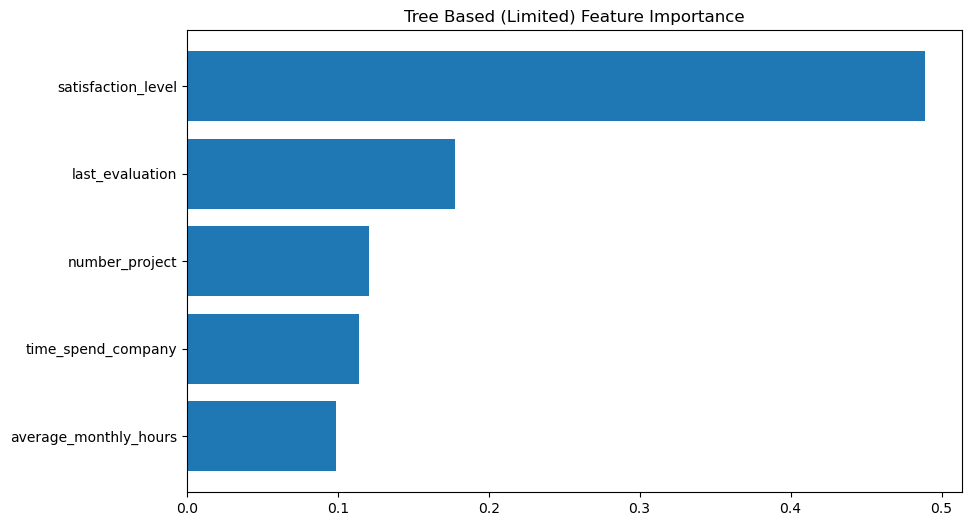

In [466]:
feature_importances_dtdf1 = decision_tree1.feature_importances_
features = X_dt1_train.columns

fi_dtdf1 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_dtdf1})
fi_dtdf1 = fi_dtdf1.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_dtdf1['Feature'], fi_dtdf1['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Limited) Feature Importance')

plt.show()

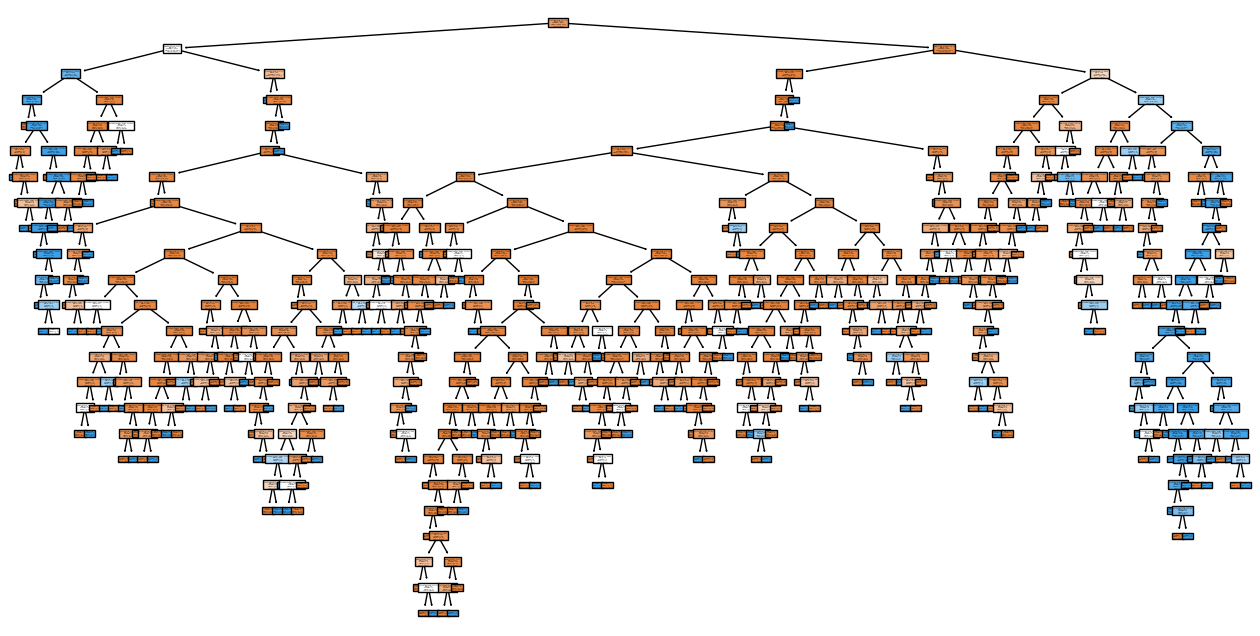

In [246]:
plt.figure(figsize=(16,8))
tree.plot_tree(decision_tree1, feature_names=X_dt1.columns, class_names=['Stayed', 'Left'], filled=True)
plt.show()

In [247]:
print("Train Accuracy:", round(decision_tree1.score(X_dt1_train, y_dt1_train), 3))
print("Test Accuracy:", round(decision_tree1.score(X_dt1_test, y_dt1_test), 3))

Train Accuracy: 1.0
Test Accuracy: 0.969


The model is showing signs of overfitting 🚩

##### Full (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [248]:
X_dt2 = df1_encoded.drop('left', axis = 1)
y_dt2 = df1_encoded['left']

In [249]:
X_dt2_train, X_dt2_test, y_dt2_train, y_dt2_test = train_test_split(X_dt2, y_dt2, test_size = 0.25, stratify = y_dt2, random_state = 0)

In [250]:
decision_tree2 = DecisionTreeClassifier(random_state = 0).fit(X_dt2_train, y_dt2_train)

In [251]:
y_pred_dt2 = decision_tree2.predict(X_dt2_test)

y_pred_dt2_proba = decision_tree2.predict_proba(X_dt2_test)[:, 1]

In [252]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt2_test, y_pred_dt2))
print("Precision:", "%.3f" % precision_score(y_dt2_test, y_pred_dt2))
print("Recall:", "%.3f" % recall_score(y_dt2_test, y_pred_dt2))
print("F1 Score:", "%.3f" % f1_score(y_dt2_test, y_pred_dt2))
print("AUC:", "%.3f" % roc_auc_score(y_dt2_test, y_pred_dt2_proba))

Accuracy: 0.965
Precision: 0.882
Recall: 0.914
F1 Score: 0.897
AUC: 0.945


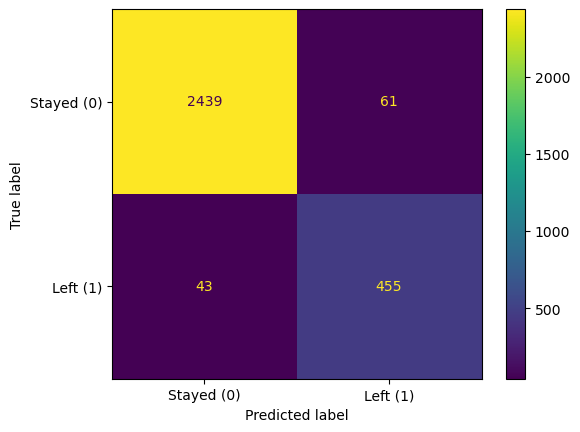

In [253]:
cm_dt2 = metrics.confusion_matrix(y_dt2_test, y_pred_dt2, labels = decision_tree2.classes_)
disp_dt2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_dt2, display_labels = ['Stayed (0)', 'Left (1)'])
disp_dt2.plot(values_format='')

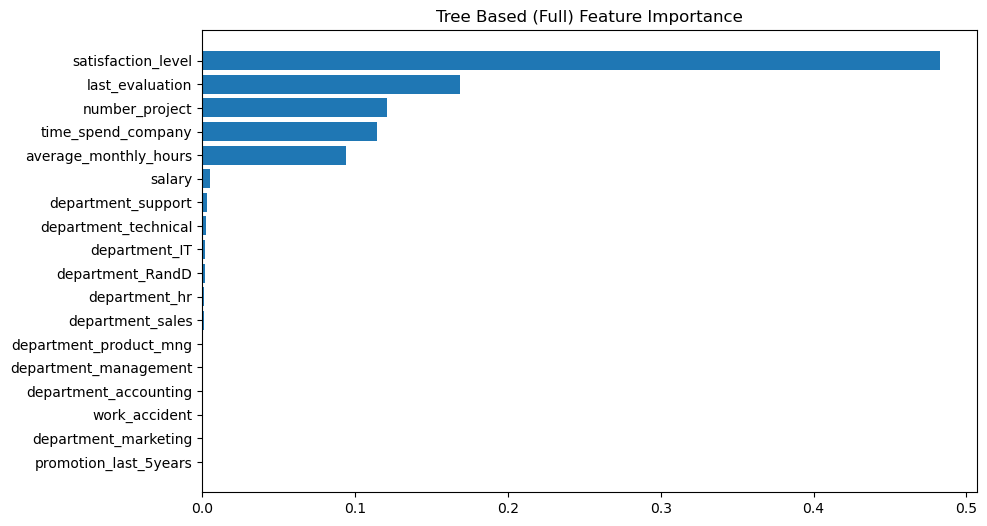

In [467]:
feature_importances_dtdf2 = decision_tree2.feature_importances_
features = X_dt2_train.columns

fi_dtdf2 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_dtdf2})
fi_dtdf2 = fi_dtdf2.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_dtdf2['Feature'], fi_dtdf2['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Full) Feature Importance')

plt.show()

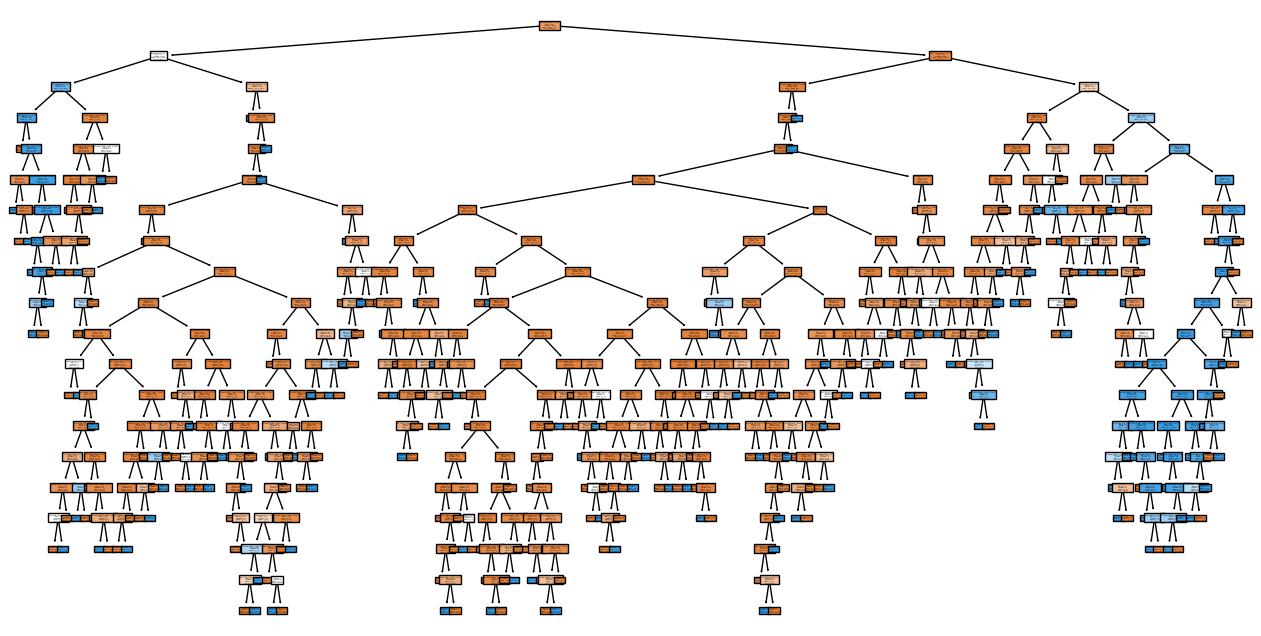

In [255]:
plt.figure(figsize=(16,8))
tree.plot_tree(decision_tree2, feature_names=X_dt2.columns, class_names=['Stayed', 'Left'], filled=True)
plt.show()

In [256]:
print("Train Accuracy:", round(decision_tree2.score(X_dt2_train, y_dt2_train), 3))
print("Test Accuracy:", round(decision_tree2.score(X_dt2_test, y_dt2_test), 3))

Train Accuracy: 1.0
Test Accuracy: 0.965


The model is showing signs of overfitting 🚩

##### Overworked (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` (`overworked`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [257]:
X_dt3 = df1_overworked.drop('left', axis = 1)
y_dt3 = df1_overworked['left']

In [258]:
X_dt3_train, X_dt3_test, y_dt3_train, y_dt3_test = train_test_split(X_dt3, y_dt3, test_size = 0.25, stratify = y_dt3, random_state = 0)

In [259]:
decision_tree3 = DecisionTreeClassifier(random_state = 0).fit(X_dt3_train, y_dt3_train)

In [260]:
y_pred_dt3 = decision_tree3.predict(X_dt3_test)

y_pred_dt3_proba = decision_tree3.predict_proba(X_dt3_test)[:, 1]

In [261]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt3_test, y_pred_dt3))
print("Precision:", "%.3f" % precision_score(y_dt3_test, y_pred_dt3))
print("Recall:", "%.3f" % recall_score(y_dt3_test, y_pred_dt3))
print("F1 Score:", "%.3f" % f1_score(y_dt3_test, y_pred_dt3))
print("AUC:", "%.3f" % roc_auc_score(y_dt3_test, y_pred_dt3_proba))

Accuracy: 0.942
Precision: 0.818
Recall: 0.839
F1 Score: 0.829
AUC: 0.906


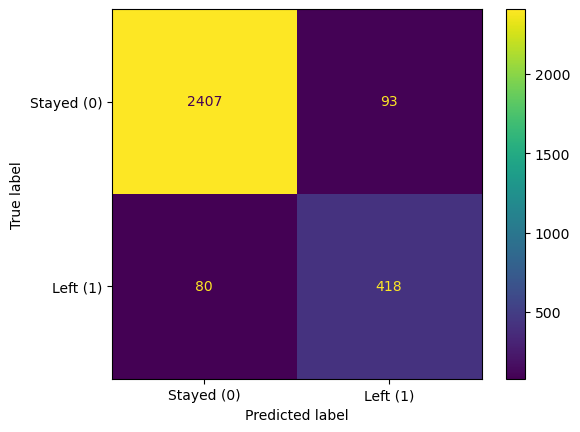

In [262]:
cm_dt3 = metrics.confusion_matrix(y_dt3_test, y_pred_dt3, labels = decision_tree2.classes_)
disp_dt3 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_dt3, display_labels = ['Stayed (0)', 'Left (1)'])
disp_dt3.plot(values_format='')

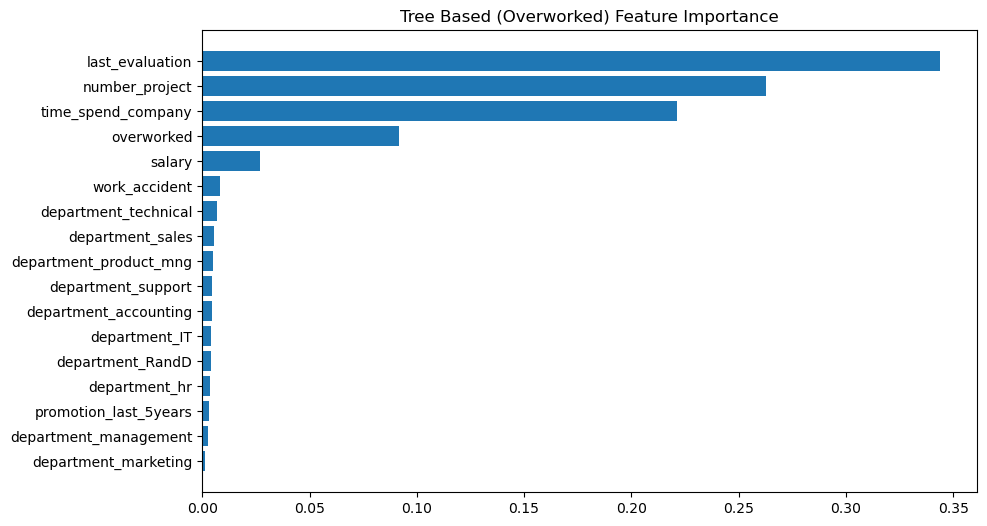

In [468]:
feature_importances_dtdf3 = decision_tree3.feature_importances_
features = X_dt3_train.columns

fi_dtdf3 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_dtdf3})
fi_dtdf3 = fi_dtdf3.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_dtdf3['Feature'], fi_dtdf3['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Overworked) Feature Importance')

plt.show()

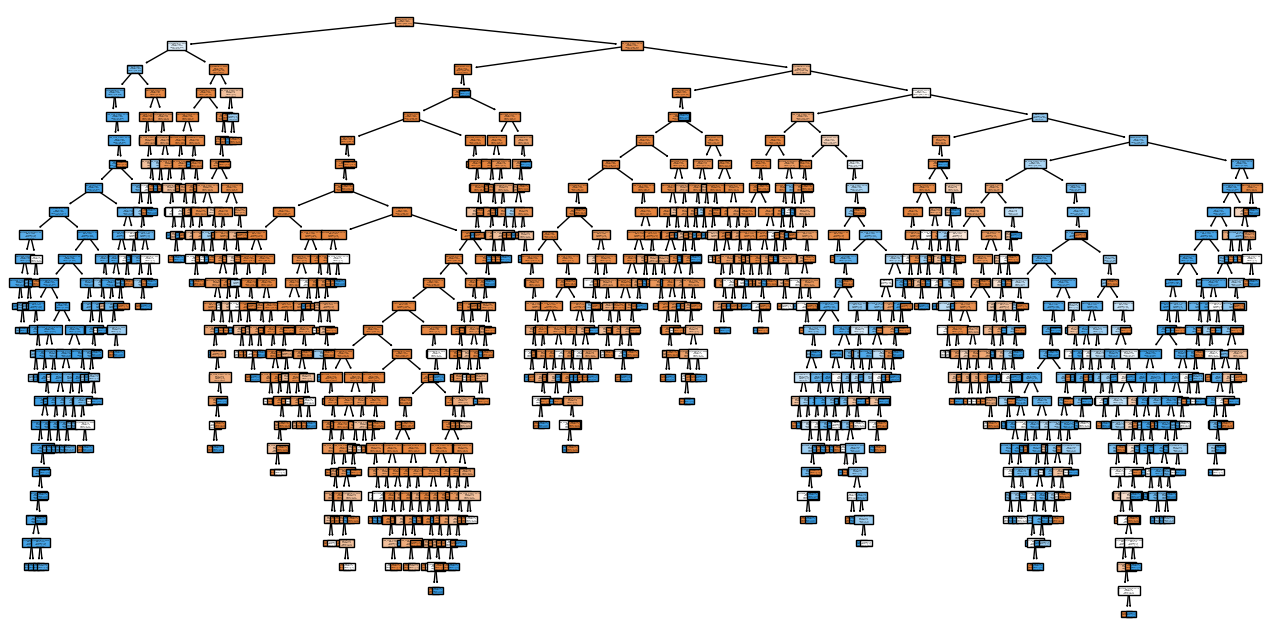

In [264]:
plt.figure(figsize=(16,8))
tree.plot_tree(decision_tree3, feature_names=X_dt3.columns, class_names=['Stayed', 'Left'], filled=True)
plt.show()

In [265]:
print("Train Accuracy:", round(decision_tree3.score(X_dt3_train, y_dt3_train), 3))
print("Test Accuracy:", round(decision_tree3.score(X_dt3_test, y_dt3_test), 3))

Train Accuracy: 0.993
Test Accuracy: 0.942


The overfitting is a bit better with this dataframe

#### Tuned Tree

In [266]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

##### Limited (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`)

In [267]:
tuned_decision_tree1 = DecisionTreeClassifier(random_state = 0)

In [268]:
tree1_para = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [269]:
%%time

tree1_grid = GridSearchCV(tuned_decision_tree1,
                   tree1_para,
                   scoring = scoring,
                   cv = 5,
                   refit = 'roc_auc',
                   n_jobs = -1)

tree1_grid.fit(X_dt1_train, y_dt1_train);

CPU times: total: 406 ms
Wall time: 1 s


In [270]:
print(tree1_grid.best_estimator_)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, random_state=0)


In [271]:
y_pred_tuned_tree1 = tree1_grid.predict(X_dt1_test)

y_pred_tuned_tree1_proba = tree1_grid.predict_proba(X_dt1_test)[:, 1]

In [272]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt1_test, y_pred_tuned_tree1))
print("Precision:", "%.3f" % precision_score(y_dt1_test, y_pred_tuned_tree1))
print("Recall:", "%.3f" % recall_score(y_dt1_test, y_pred_tuned_tree1))
print("F1 Score:", "%.3f" % f1_score(y_dt1_test, y_pred_tuned_tree1))
print("AUC:", "%.3f" % roc_auc_score(y_dt1_test, y_pred_tuned_tree1_proba))

Accuracy: 0.978
Precision: 0.958
Recall: 0.908
F1 Score: 0.932
AUC: 0.979


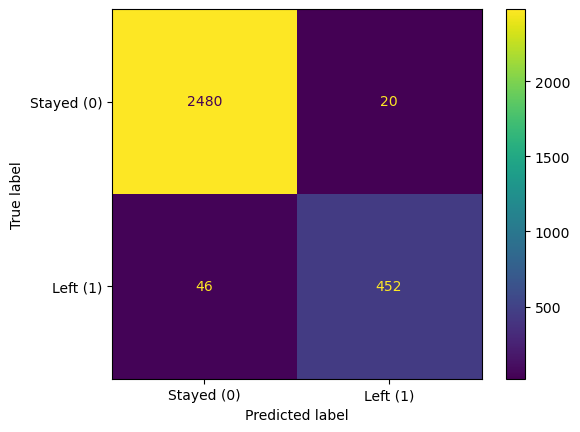

In [273]:
cm_tt1 = metrics.confusion_matrix(y_dt1_test, y_pred_tuned_tree1, labels = tree1_grid.classes_)
disp_tt1 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_tt1, display_labels = ['Stayed (0)', 'Left (1)'])
disp_tt1.plot(values_format='')

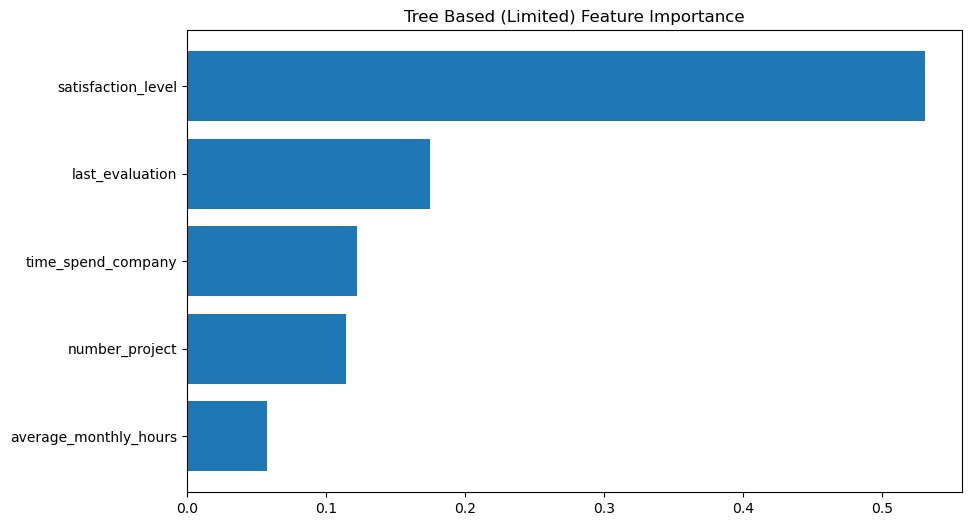

In [469]:
feature_importances_tdtdf1 = tree1_grid.best_estimator_.feature_importances_
features = X_dt1_train.columns

fi_tdtdf1 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_tdtdf1})
fi_tdtdf1 = fi_tdtdf1.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_tdtdf1['Feature'], fi_tdtdf1['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Limited) Feature Importance')

plt.show()

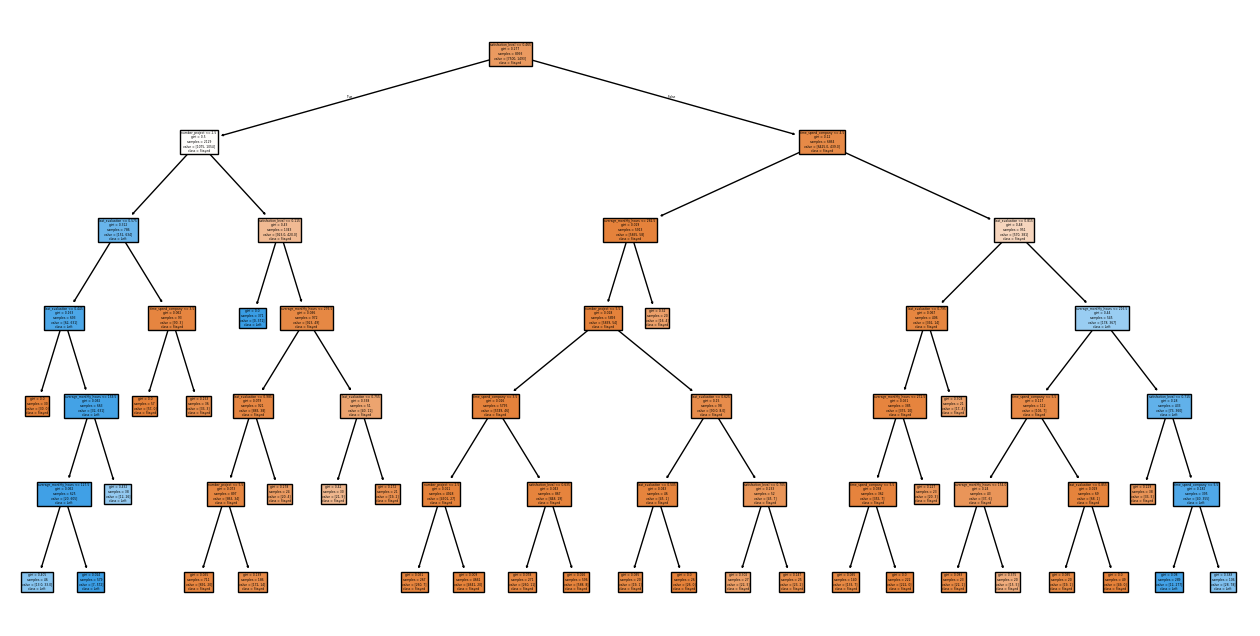

In [277]:
plt.figure(figsize=(16,8))
tree.plot_tree(best_tree1, feature_names=X_dt1.columns, class_names=['Stayed', 'Left'], filled=True)
plt.show()

In [278]:
print("Train Accuracy:", round(tree1_grid.score(X_dt1_train, y_dt1_train), 3))
print("Test Accuracy:", round(tree1_grid.score(X_dt1_test, y_dt1_test), 3))

Train Accuracy: 0.983
Test Accuracy: 0.979


The model is performing well, there are no meaningfull signs of overfitting.

##### Full (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [279]:
tuned_decision_tree2 = DecisionTreeClassifier(random_state = 0)

In [280]:
tree2_para = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [281]:
%%time

tree2_grid = GridSearchCV(tuned_decision_tree2,
                   tree2_para,
                   scoring = scoring,
                   cv = 5,
                   refit = 'roc_auc',
                   n_jobs = -1)

tree2_grid.fit(X_dt2_train, y_dt2_train);

CPU times: total: 406 ms
Wall time: 1.23 s


In [282]:
print(tree2_grid.best_estimator_)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, random_state=0)


In [283]:
y_pred_tuned_tree2 = tree2_grid.predict(X_dt2_test)

y_pred_tuned_tree2_proba = tree2_grid.predict_proba(X_dt2_test)[:, 1]

In [284]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt2_test, y_pred_tuned_tree2))
print("Precision:", "%.3f" % precision_score(y_dt2_test, y_pred_tuned_tree2))
print("Recall:", "%.3f" % recall_score(y_dt2_test, y_pred_tuned_tree2))
print("F1 Score:", "%.3f" % f1_score(y_dt2_test, y_pred_tuned_tree2))
print("AUC:", "%.3f" % roc_auc_score(y_dt2_test, y_pred_tuned_tree2_proba))

Accuracy: 0.978
Precision: 0.958
Recall: 0.908
F1 Score: 0.932
AUC: 0.979


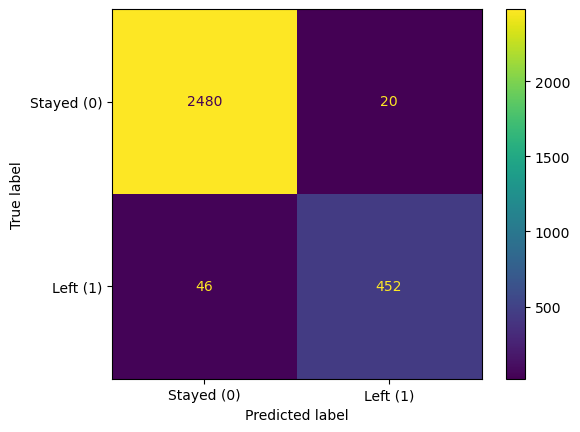

In [285]:
cm_tt2 = metrics.confusion_matrix(y_dt2_test, y_pred_tuned_tree2, labels = tree2_grid.classes_)
disp_tt2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_tt2, display_labels = ['Stayed (0)', 'Left (1)'])
disp_tt2.plot(values_format='')

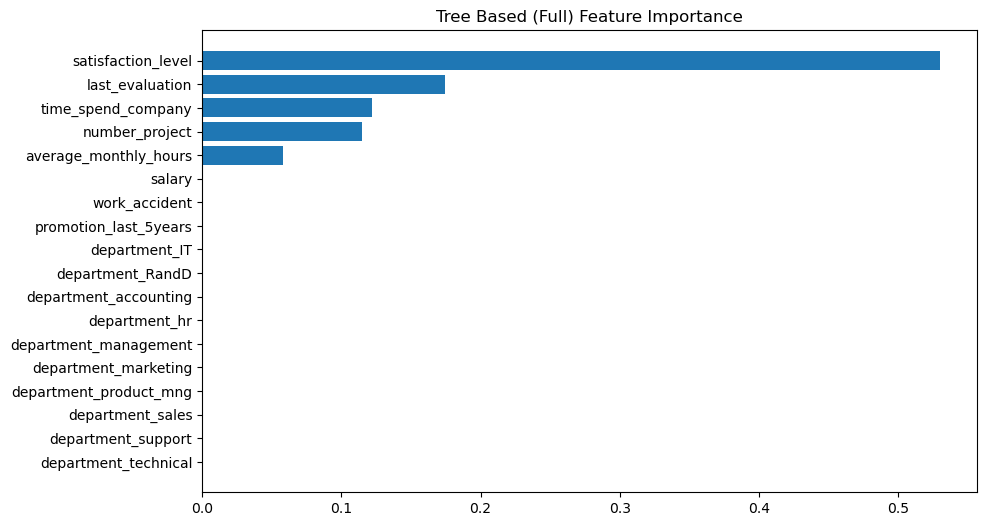

In [470]:
feature_importances_tdtdf2 = tree2_grid.best_estimator_.feature_importances_
features = X_dt2_train.columns

fi_tdtdf2 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_tdtdf2})
fi_tdtdf2 = fi_tdtdf2.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_tdtdf2['Feature'], fi_tdtdf2['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Full) Feature Importance')

plt.show()

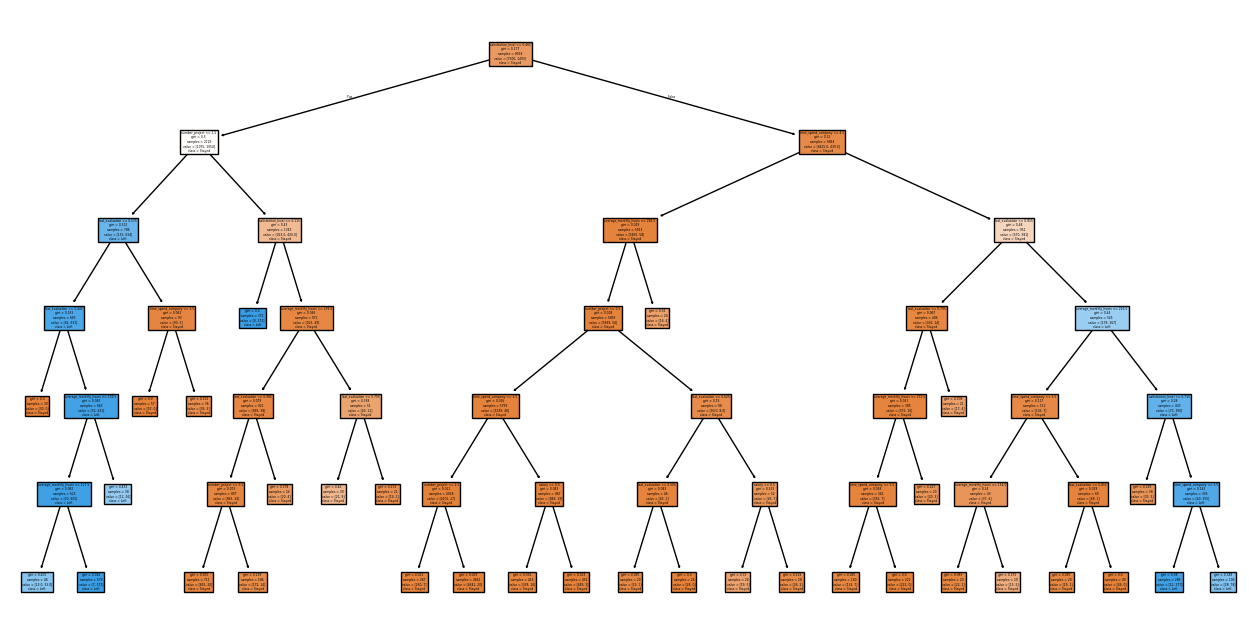

In [289]:
plt.figure(figsize=(16,8))
tree.plot_tree(best_tree2, feature_names=X_dt2.columns, class_names=['Stayed', 'Left'], filled=True)
plt.show()

In [290]:
print("Train Accuracy:", round(tree2_grid.score(X_dt2_train, y_dt2_train), 3))
print("Test Accuracy:", round(tree2_grid.score(X_dt2_test, y_dt2_test), 3))

Train Accuracy: 0.983
Test Accuracy: 0.979


The model is performing well, there are no meaningfull signs of overfitting.

##### Overworked (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` (`overworked`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [291]:
tuned_decision_tree3 = DecisionTreeClassifier(random_state = 0)

In [292]:
tree3_para = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [293]:
%%time

tree3_grid = GridSearchCV(tuned_decision_tree3,
                   tree3_para,
                   scoring = scoring,
                   cv = 5,
                   refit = 'roc_auc',
                   n_jobs = -1)

tree3_grid.fit(X_dt3_train, y_dt3_train);

CPU times: total: 375 ms
Wall time: 1.09 s


In [294]:
print(tree3_grid.best_estimator_)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=50, random_state=0)


In [295]:
y_pred_tuned_tree3 = tree3_grid.predict(X_dt3_test)

y_pred_tuned_tree3_proba = tree3_grid.predict_proba(X_dt3_test)[:, 1]

In [296]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt3_test, y_pred_tuned_tree3))
print("Precision:", "%.3f" % precision_score(y_dt3_test, y_pred_tuned_tree3))
print("Recall:", "%.3f" % recall_score(y_dt3_test, y_pred_tuned_tree3))
print("F1 Score:", "%.3f" % f1_score(y_dt3_test, y_pred_tuned_tree3))
print("AUC:", "%.3f" % roc_auc_score(y_dt3_test, y_pred_tuned_tree3_proba))

Accuracy: 0.951
Precision: 0.852
Recall: 0.855
F1 Score: 0.854
AUC: 0.961


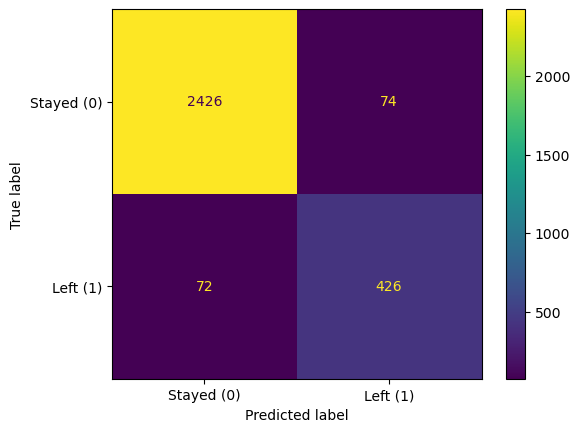

In [297]:
cm_tt3 = metrics.confusion_matrix(y_dt3_test, y_pred_tuned_tree3, labels = tree3_grid.classes_)
disp_tt3 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_tt3, display_labels = ['Stayed (0)', 'Left (1)'])
disp_tt3.plot(values_format='')

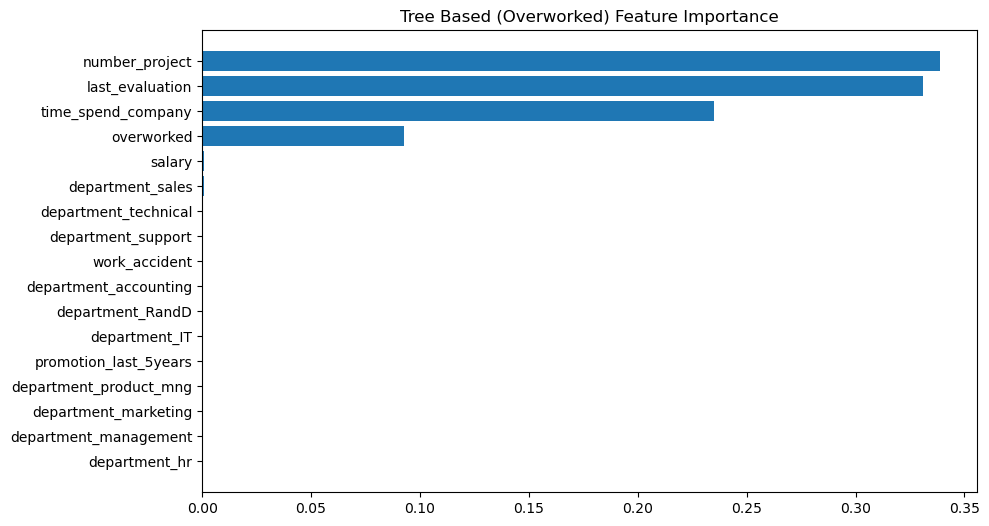

In [471]:
feature_importances_tdtdf3 = tree3_grid.best_estimator_.feature_importances_
features = X_dt3_train.columns

fi_tdtdf3 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_tdtdf3})
fi_tdtdf3 = fi_tdtdf3.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_tdtdf3['Feature'], fi_tdtdf3['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Overworked) Feature Importance')

plt.show()

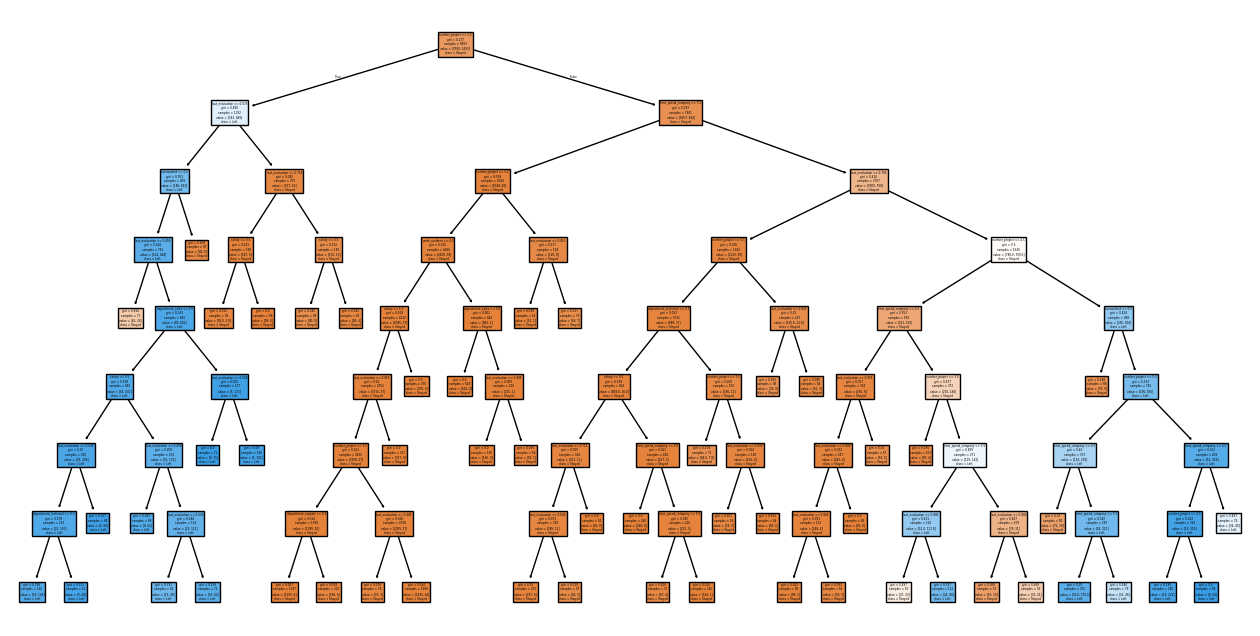

In [301]:
plt.figure(figsize=(16,8))
tree.plot_tree(best_tree3, feature_names=X_dt3.columns, class_names=['Stayed', 'Left'], filled=True)
plt.show()

In [302]:
print("Train Accuracy:", round(tree3_grid.score(X_dt3_train, y_dt3_train), 3))
print("Test Accuracy:", round(tree3_grid.score(X_dt3_test, y_dt3_test), 3))

Train Accuracy: 0.974
Test Accuracy: 0.961


The model is performing well, there are no meaningfull signs of overfitting.

#### Random Forest

##### Limited (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`) 

In [303]:
random_forest_tree1 = RandomForestClassifier(random_state = 0)

In [304]:
rf_tree1_para = {'max_depth': [3, 5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [300, 500]}

In [305]:
%%time

rf_tree1_grid = GridSearchCV(random_forest_tree1,
                   rf_tree1_para,
                   scoring = scoring,
                   cv = 5,
                   refit = 'roc_auc',
                   n_jobs = -1)

rf_tree1_grid.fit(X_dt1_train, y_dt1_train);

CPU times: total: 2.91 s
Wall time: 2min 9s


In [306]:
print('Best Score :', rf_tree1_grid.best_score_)
print('Best Parameters :', rf_tree1_grid.best_params_)

Best Score : 0.9811843699729899
Best Parameters : {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}


In [307]:
y_pred_rf_tree1 = rf_tree1_grid.predict(X_dt1_test)

y_pred_rf_tree1_proba = rf_tree1_grid.predict_proba(X_dt1_test)[:, 1]

In [308]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt1_test, y_pred_rf_tree1))
print("Precision:", "%.3f" % precision_score(y_dt1_test, y_pred_rf_tree1))
print("Recall:", "%.3f" % recall_score(y_dt1_test, y_pred_rf_tree1))
print("F1 Score:", "%.3f" % f1_score(y_dt1_test, y_pred_rf_tree1))
print("AUC:", "%.3f" % roc_auc_score(y_dt1_test, y_pred_rf_tree1_proba))

Accuracy: 0.979
Precision: 0.964
Recall: 0.910
F1 Score: 0.936
AUC: 0.984


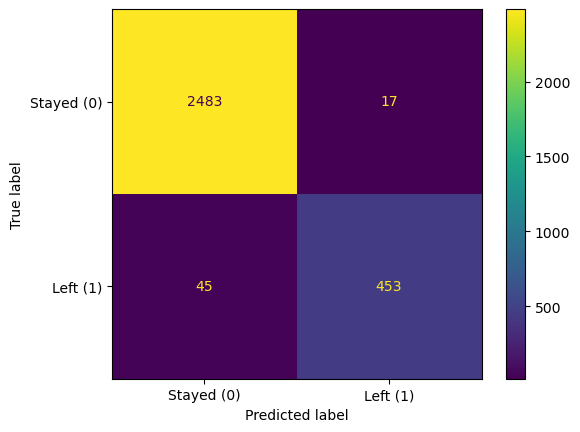

In [309]:
cm_rft1 = metrics.confusion_matrix(y_dt1_test, y_pred_rf_tree1, labels = rf_tree1_grid.classes_)
disp_rft1 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rft1, display_labels = ['Stayed (0)', 'Left (1)'])
disp_rft1.plot(values_format='')

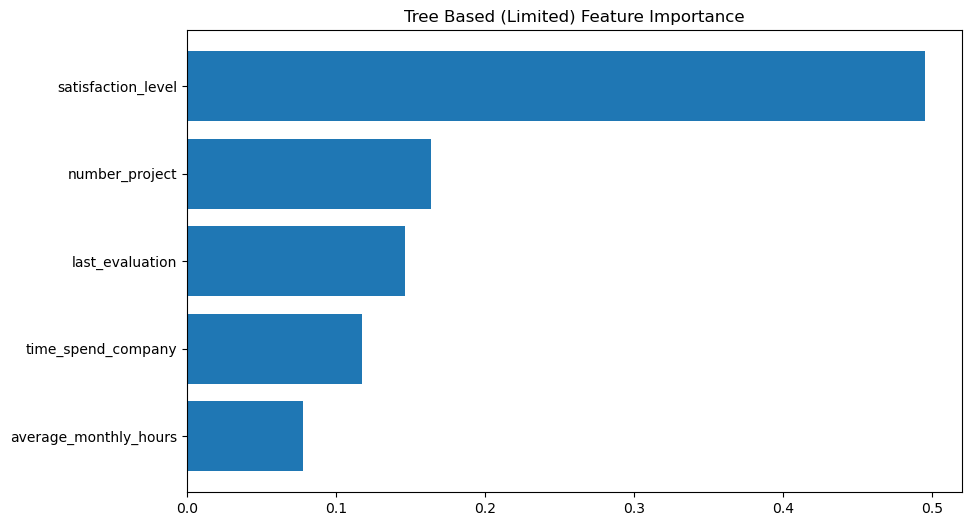

In [472]:
feature_importances_rfdf1 = rf_tree1_grid.best_estimator_.feature_importances_
features = X_dt1_train.columns

fi_rfdf1 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rfdf1})
fi_rfdf1 = fi_rfdf1.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_rfdf1['Feature'], fi_rfdf1['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Limited) Feature Importance')

plt.show()

In [311]:
print("Train Accuracy:", round(rf_tree1_grid.score(X_dt1_train, y_dt1_train), 3))
print("Test Accuracy:", round(rf_tree1_grid.score(X_dt1_test, y_dt1_test), 3))

Train Accuracy: 0.986
Test Accuracy: 0.984


The model performs excellent with no signs of overfitting

##### Full (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [316]:
random_forest_tree2 = RandomForestClassifier(random_state = 0)

In [317]:
rf_tree2_para = {'max_depth': [3, 5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [300, 500]}

In [318]:
%%time

rf_tree2_grid = GridSearchCV(random_forest_tree2,
                   rf_tree2_para,
                   scoring = scoring,
                   cv = 5,
                   refit = 'roc_auc',
                   n_jobs = -1)

rf_tree2_grid.fit(X_dt2_train, y_dt2_train);

CPU times: total: 5.2 s
Wall time: 3min 10s


In [319]:
print('Best Score :', rf_tree2_grid.best_score_)
print('Best Parameters :', rf_tree2_grid.best_params_)

Best Score : 0.9802691088116242
Best Parameters : {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}


In [320]:
y_pred_rf_tree2 = rf_tree2_grid.predict(X_dt2_test)

y_pred_rf_tree2_proba = rf_tree2_grid.predict_proba(X_dt2_test)[:, 1]

In [321]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt2_test, y_pred_rf_tree2))
print("Precision:", "%.3f" % precision_score(y_dt2_test, y_pred_rf_tree2))
print("Recall:", "%.3f" % recall_score(y_dt2_test, y_pred_rf_tree2))
print("F1 Score:", "%.3f" % f1_score(y_dt2_test, y_pred_rf_tree2))
print("AUC:", "%.3f" % roc_auc_score(y_dt2_test, y_pred_rf_tree2_proba))

Accuracy: 0.979
Precision: 0.964
Recall: 0.910
F1 Score: 0.936
AUC: 0.984


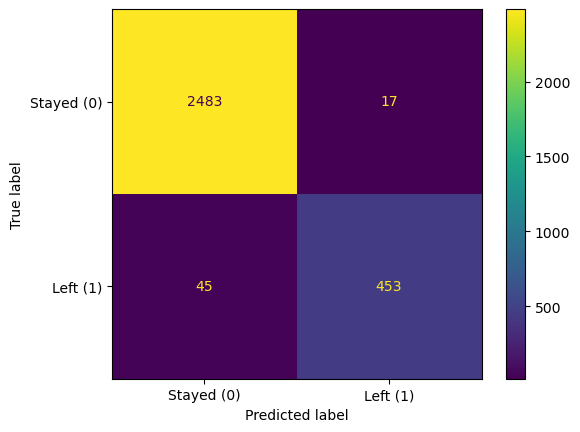

In [322]:
cm_rft2 = metrics.confusion_matrix(y_dt2_test, y_pred_rf_tree2, labels = rf_tree2_grid.classes_)
disp_rft2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rft2, display_labels = ['Stayed (0)', 'Left (1)'])
disp_rft2.plot(values_format='')

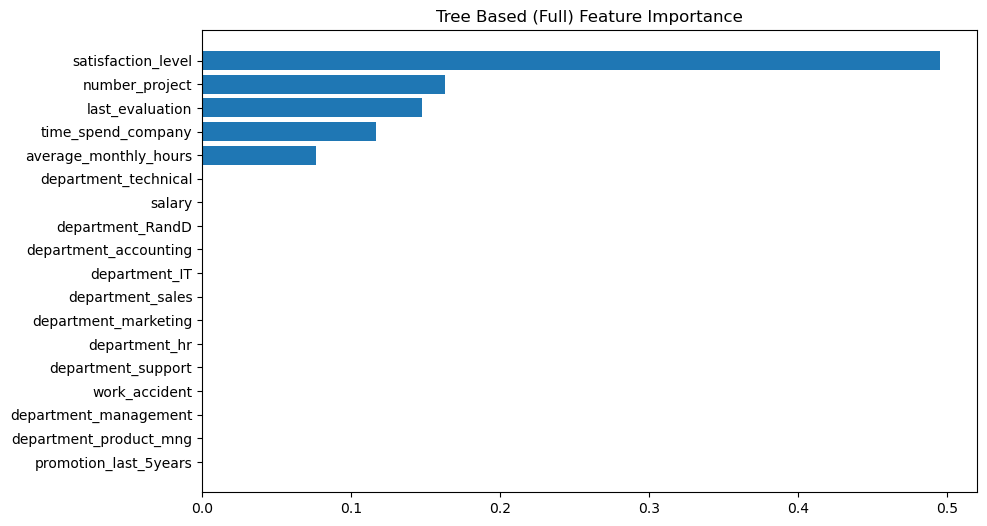

In [473]:
feature_importances_rfdf2 = rf_tree2_grid.best_estimator_.feature_importances_
features = X_dt2_train.columns

fi_rfdf2 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rfdf2})
fi_rfdf2 = fi_rfdf2.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_rfdf2['Feature'], fi_rfdf2['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Full) Feature Importance')

plt.show()

In [324]:
print("Train Accuracy:", round(rf_tree2_grid.score(X_dt2_train, y_dt2_train), 3))
print("Test Accuracy:", round(rf_tree2_grid.score(X_dt2_test, y_dt2_test), 3))

Train Accuracy: 0.987
Test Accuracy: 0.984


The model performs excellent with no signs of overfitting

##### Overworked (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` (`overworked`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [325]:
random_forest_tree3 = RandomForestClassifier(random_state = 0)

In [326]:
rf_tree3_para = {'max_depth': [3, 5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [300, 500]}

In [327]:
%%time

rf_tree3_grid = GridSearchCV(random_forest_tree3,
                   rf_tree3_para,
                   scoring = scoring,
                   cv = 5,
                   refit = 'roc_auc',
                   n_jobs = -1)

rf_tree3_grid.fit(X_dt3_train, y_dt3_train);

CPU times: total: 3.02 s
Wall time: 2min 25s


In [328]:
print('Best Score :', rf_tree3_grid.best_score_)
print('Best Parameters :', rf_tree3_grid.best_params_)

Best Score : 0.9648914090966907
Best Parameters : {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}


In [329]:
y_pred_rf_tree3 = rf_tree3_grid.predict(X_dt3_test)

y_pred_rf_tree3_proba = rf_tree3_grid.predict_proba(X_dt3_test)[:, 1]

In [330]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt3_test, y_pred_rf_tree3))
print("Precision:", "%.3f" % precision_score(y_dt3_test, y_pred_rf_tree3))
print("Recall:", "%.3f" % recall_score(y_dt3_test, y_pred_rf_tree3))
print("F1 Score:", "%.3f" % f1_score(y_dt3_test, y_pred_rf_tree3))
print("AUC:", "%.3f" % roc_auc_score(y_dt3_test, y_pred_rf_tree3_proba))

Accuracy: 0.961
Precision: 0.870
Recall: 0.900
F1 Score: 0.885
AUC: 0.968


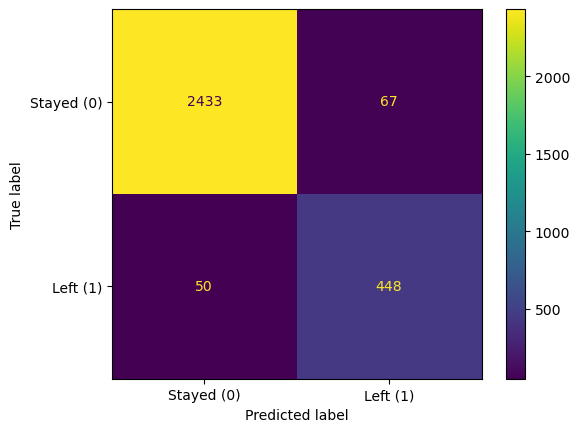

In [331]:
cm_rft3 = metrics.confusion_matrix(y_dt3_test, y_pred_rf_tree3, labels = rf_tree3_grid.classes_)
disp_rft3 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rft3, display_labels = ['Stayed (0)', 'Left (1)'])
disp_rft3.plot(values_format='')

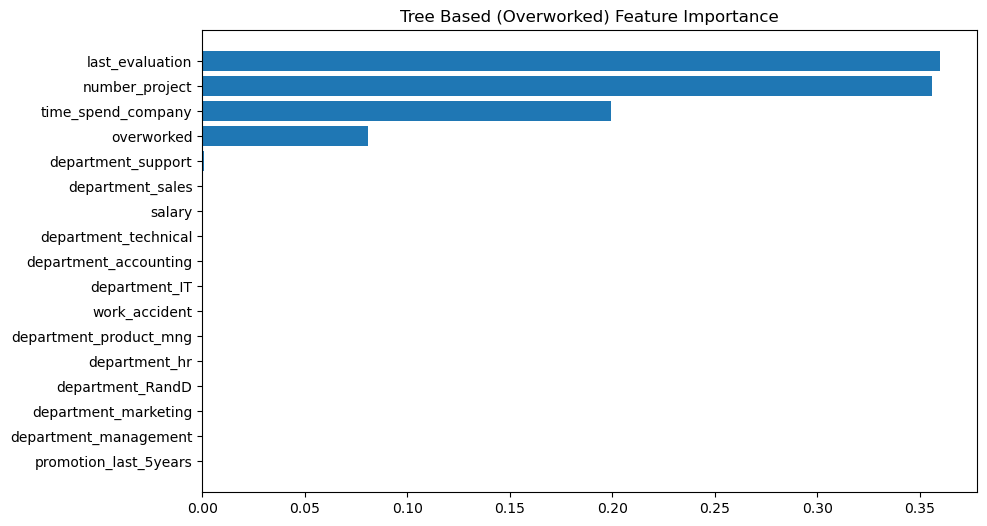

In [474]:
feature_importances_rfdf3 = rf_tree3_grid.best_estimator_.feature_importances_
features = X_dt3_train.columns

fi_rfdf3 = pd.DataFrame({'Feature': features, 'Importance': feature_importances_rfdf3})
fi_rfdf3 = fi_rfdf3.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi_rfdf3['Feature'], fi_rfdf3['Importance'])
plt.gca().invert_yaxis()
plt.title('Tree Based (Overworked) Feature Importance')

plt.show()

In [333]:
print("Train Accuracy:", round(rf_tree3_grid.score(X_dt3_train, y_dt3_train), 3))
print("Test Accuracy:", round(rf_tree3_grid.score(X_dt3_test, y_dt3_test), 3))

Train Accuracy: 0.975
Test Accuracy: 0.968


The model performs excellent with no signs of overfitting

#### XGBoost 

##### Limited (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`) 

In [334]:
xgb1 = XGBClassifier(objective = 'binary:logistic', random_state = 0)

In [335]:
xgb1_para = {'max_depth': [3, 5, None],
               'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
               'n_estimators': [100,300,500],
               'subsample': [0.7],
               'colsample_bytree': [0.7]}

In [336]:
%%time

xgb1_grid = GridSearchCV(xgb1,
                      xgb1_para,
                      scoring = scoring,
                      cv = 5,
                      refit = 'roc_auc',
                      n_jobs=-1)


xgb1_grid.fit(X_dt1_train, y_dt1_train);

CPU times: total: 1.67 s
Wall time: 10.3 s


In [337]:
print('Best Score :', xgb1_grid.best_score_)
print('Best Parameters :', xgb1_grid.best_params_)

Best Score : 0.9823691888696849
Best Parameters : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}


In [338]:
y_pred_xgb1 = xgb1_grid.predict(X_dt1_test)

y_pred_xgb1_proba = xgb1_grid.predict_proba(X_dt1_test)[:, 1]

In [339]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt1_test, y_pred_xgb1))
print("Precision:", "%.3f" % precision_score(y_dt1_test, y_pred_xgb1))
print("Recall:", "%.3f" % recall_score(y_dt1_test, y_pred_xgb1))
print("F1 Score:", "%.3f" % f1_score(y_dt1_test, y_pred_xgb1))
print("AUC:", "%.3f" % roc_auc_score(y_dt1_test, y_pred_xgb1_proba))

Accuracy: 0.982
Precision: 0.976
Recall: 0.912
F1 Score: 0.943
AUC: 0.986


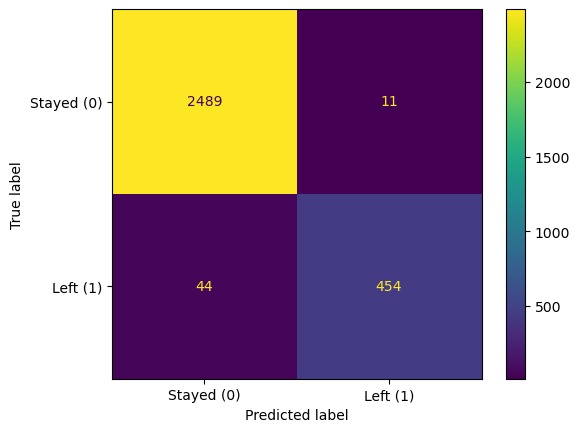

In [340]:
cm_xgb1 = metrics.confusion_matrix(y_dt1_test, y_pred_xgb1, labels = xgb1_grid.classes_)
disp_xgb1 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb1, display_labels = ['Stayed (0)', 'Left (1)'])
disp_xgb1.plot(values_format='')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

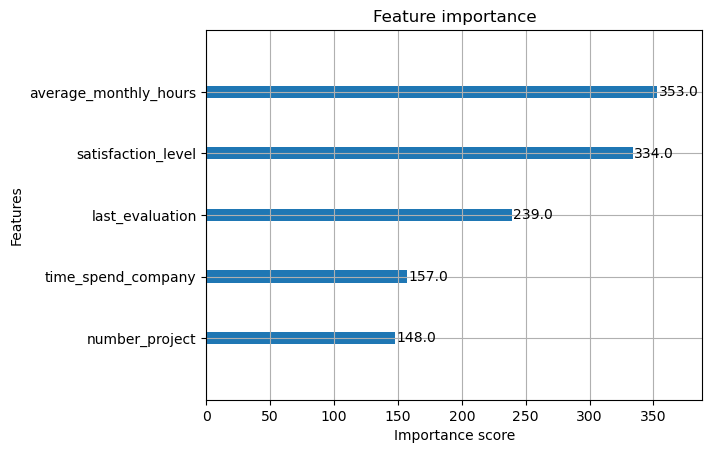

In [341]:
plot_importance(xgb1_grid.best_estimator_)

In [342]:
print("Train Accuracy:", round(xgb1_grid.score(X_dt1_train, y_dt1_train), 3))
print("Test Accuracy:", round(xgb1_grid.score(X_dt1_test, y_dt1_test), 3))

Train Accuracy: 0.992
Test Accuracy: 0.986


The model shows mild signs of overfitting

##### Full (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [343]:
xgb2 = XGBClassifier(objective = 'binary:logistic', random_state = 0)

In [344]:
xgb2_para = {'max_depth': [3, 5, None],
               'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
               'n_estimators': [100,300,500],
               'subsample': [0.7],
               'colsample_bytree': [0.7]}

In [345]:
%%time

xgb2_grid = GridSearchCV(xgb2,
                      xgb1_para,
                      scoring = scoring,
                      cv = 5,
                      refit = 'roc_auc',
                      n_jobs=-1)


xgb2_grid.fit(X_dt2_train, y_dt2_train);

CPU times: total: 1.61 s
Wall time: 11.2 s


In [346]:
print('Best Score :', xgb2_grid.best_score_)
print('Best Parameters :', xgb2_grid.best_params_)

Best Score : 0.984555493703845
Best Parameters : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}


In [347]:
y_pred_xgb2 = xgb2_grid.predict(X_dt2_test)

y_pred_xgb2_proba = xgb2_grid.predict_proba(X_dt2_test)[:, 1]

In [348]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt2_test, y_pred_xgb2))
print("Precision:", "%.3f" % precision_score(y_dt2_test, y_pred_xgb2))
print("Recall:", "%.3f" % recall_score(y_dt2_test, y_pred_xgb2))
print("F1 Score:", "%.3f" % f1_score(y_dt2_test, y_pred_xgb2))
print("AUC:", "%.3f" % roc_auc_score(y_dt2_test, y_pred_xgb2_proba))

Accuracy: 0.982
Precision: 0.974
Recall: 0.918
F1 Score: 0.945
AUC: 0.986


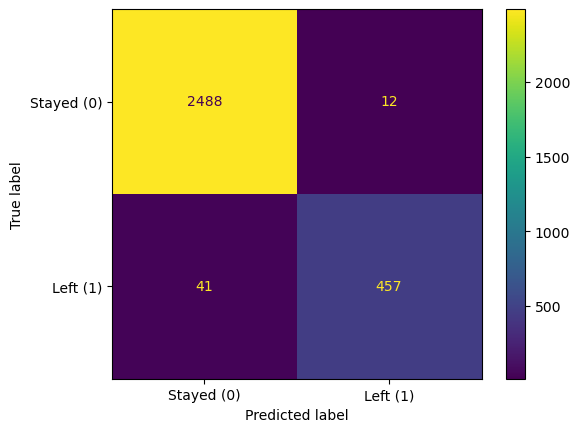

In [349]:
cm_xgb2 = metrics.confusion_matrix(y_dt2_test, y_pred_xgb2, labels = xgb2_grid.classes_)
disp_xgb2 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb2, display_labels = ['Stayed (0)', 'Left (1)'])
disp_xgb2.plot(values_format='')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

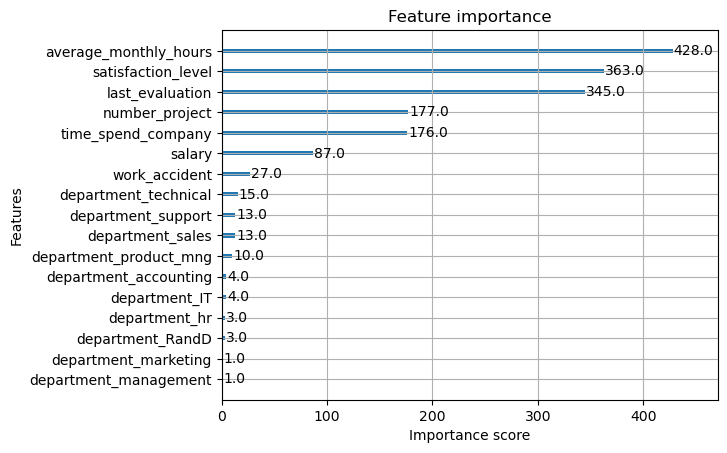

In [350]:
plot_importance(xgb2_grid.best_estimator_)

In [351]:
print("Train Accuracy:", round(xgb2_grid.score(X_dt2_train, y_dt2_train), 3))
print("Test Accuracy:", round(xgb2_grid.score(X_dt2_test, y_dt2_test), 3))

Train Accuracy: 0.995
Test Accuracy: 0.986


The model shows mild signs of overfitting

##### Overworked (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` (`overworked`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

In [352]:
xgb3 = XGBClassifier(objective = 'binary:logistic', random_state = 0)

In [353]:
xgb3_para = {'max_depth': [3, 5, None],
               'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
               'n_estimators': [100,300,500],
               'subsample': [0.7],
               'colsample_bytree': [0.7]}

In [354]:
%%time

xgb3_grid = GridSearchCV(xgb3,
                      xgb3_para,
                      scoring = scoring,
                      cv = 5,
                      refit = 'roc_auc',
                      n_jobs=-1)


xgb3_grid.fit(X_dt3_train, y_dt3_train);

CPU times: total: 1.25 s
Wall time: 10.8 s


In [355]:
print('Best Score :', xgb3_grid.best_score_)
print('Best Parameters :', xgb3_grid.best_params_)

Best Score : 0.9717063096226797
Best Parameters : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}


In [356]:
y_pred_xgb3 = xgb3_grid.predict(X_dt3_test)

y_pred_xgb3_proba = xgb3_grid.predict_proba(X_dt3_test)[:, 1]

In [357]:
print("Accuracy:", "%.3f" % accuracy_score(y_dt3_test, y_pred_xgb3))
print("Precision:", "%.3f" % precision_score(y_dt3_test, y_pred_xgb3))
print("Recall:", "%.3f" % recall_score(y_dt3_test, y_pred_xgb3))
print("F1 Score:", "%.3f" % f1_score(y_dt3_test, y_pred_xgb3))
print("AUC:", "%.3f" % roc_auc_score(y_dt3_test, y_pred_xgb3_proba))

Accuracy: 0.961
Precision: 0.875
Recall: 0.890
F1 Score: 0.882
AUC: 0.974


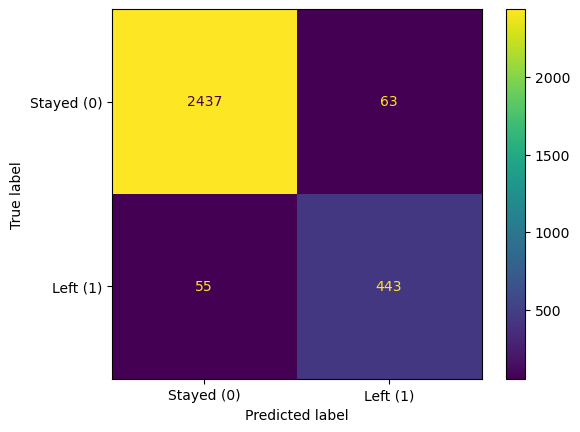

In [358]:
cm_xgb3 = metrics.confusion_matrix(y_dt3_test, y_pred_xgb3, labels = xgb3_grid.classes_)
disp_xgb3 = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_xgb3, display_labels = ['Stayed (0)', 'Left (1)'])
disp_xgb3.plot(values_format='')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

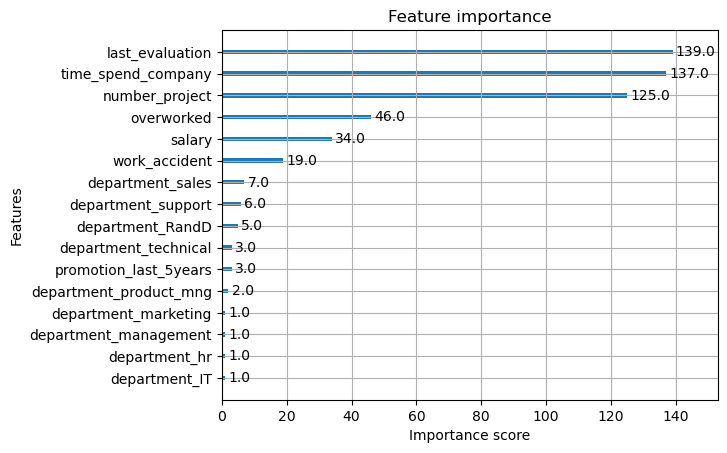

In [359]:
plot_importance(xgb3_grid.best_estimator_)

In [360]:
print("Train Accuracy:", round(xgb3_grid.score(X_dt3_train, y_dt3_train), 3))
print("Test Accuracy:", round(xgb3_grid.score(X_dt3_test, y_dt3_test), 3))

Train Accuracy: 0.974
Test Accuracy: 0.974


The model performs excellent.

## **pacE: Execute Stage**
- Interpreting model performance and results
- Sharing actionable steps with stakeholders

#### Recalling evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






### Step 4. Results and Evaluation
- Interpreting the models
- Evaluating model performance using metrics
- Preparing results, visualizations, and actionable steps to share with stakeholders




#### Model Performance by Dataset 

##### Limited features (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` and `time_spend_company`)

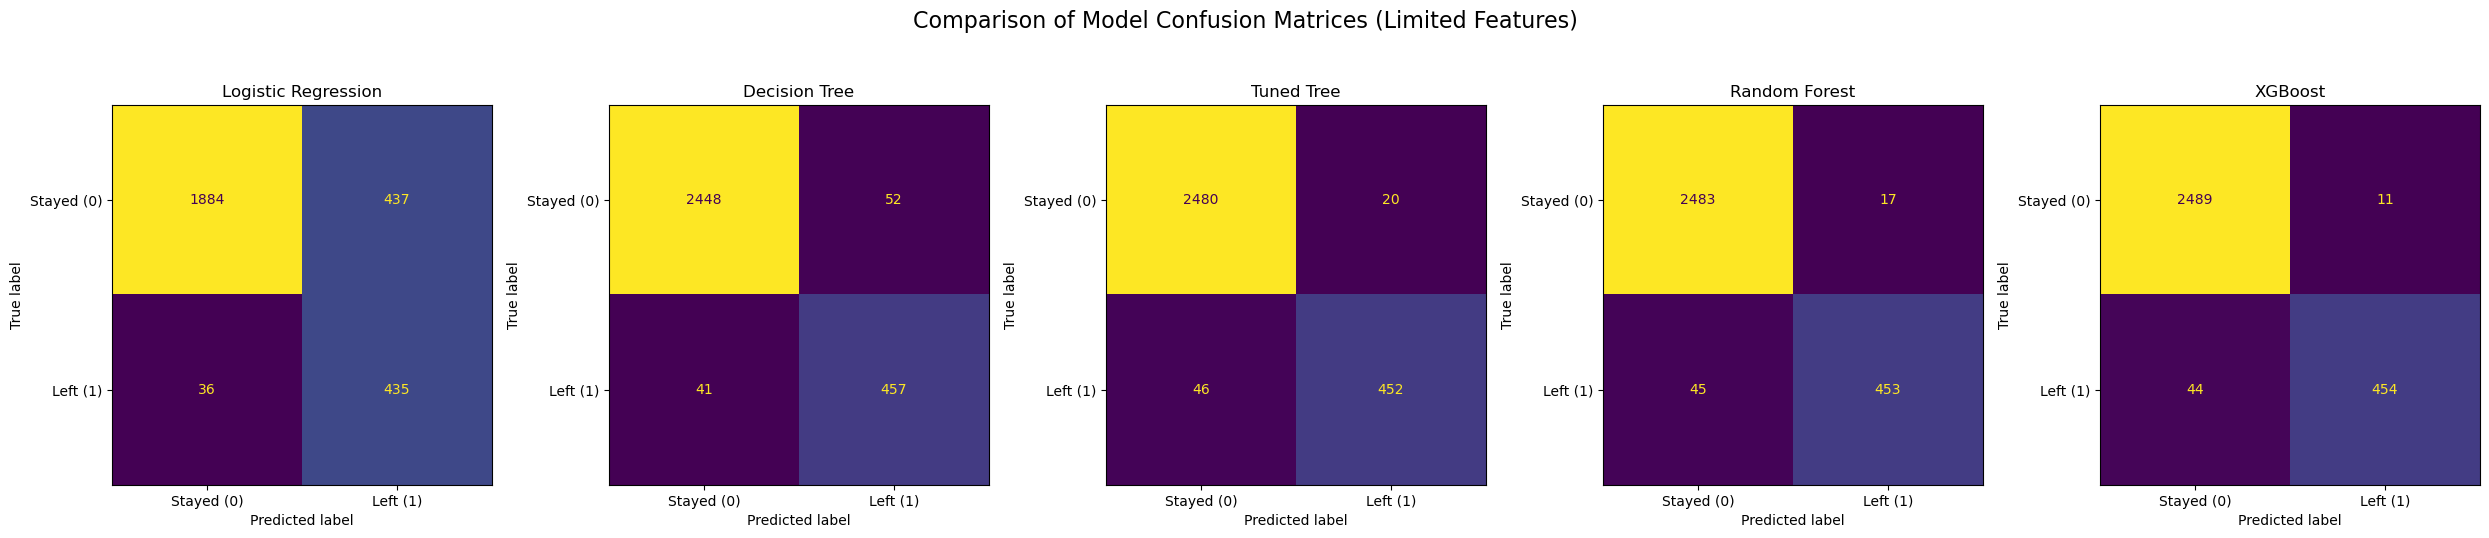

In [413]:
# Confusion matrices
cms = [
    metrics.confusion_matrix(y_lr1_test, y_pred_logreg1, labels=[0, 1]),
    metrics.confusion_matrix(y_dt1_test, y_pred_dt1, labels=[0, 1]),
    metrics.confusion_matrix(y_dt1_test, y_pred_tuned_tree1, labels=[0, 1]),
    metrics.confusion_matrix(y_dt1_test, y_pred_rf_tree1, labels=[0, 1]),
    metrics.confusion_matrix(y_dt1_test, y_pred_xgb1, labels=[0, 1])
]

# Titles
titles = ['Logistic Regression', 'Decision Tree', 'Tuned Tree', 'Random Forest', 'XGBoost']

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Create ConfusionMatrixDisplay object
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    
    # Plot directly on the given ax, and disable the colorbar
    disp.plot(ax=ax, values_format='', colorbar=False)
    
    ax.set_title(titles[i], fontsize=12)
    
fig.suptitle('Comparison of Model Confusion Matrices (Limited Features)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [414]:
models = ['Logistic Regression', 'Decision Tree', 'Tuned Tree', 'Random Forest', 'XGBoost']

# predictions
preds = [y_pred_logreg1, y_pred_dt1, y_pred_tuned_tree1, y_pred_rf_tree1, y_pred_xgb1]

# corresponding test sets
y_tests = [y_lr1_test, y_dt1_test, y_dt1_test, y_dt1_test, y_dt1_test]

# predicted probabilities for AUC (positive class)
probas = [y_pred_logreg1_proba, y_pred_dt1_proba, y_pred_tuned_tree1_proba, y_pred_rf_tree1_proba, y_pred_xgb1_proba]


In [415]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_list = []

for i in range(len(models)):
    y_true_i = y_tests[i]
    y_pred_i = preds[i]
    y_proba_i = probas[i]
    
    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    auc = roc_auc_score(y_true_i, y_proba_i)
    
    metrics_list.append({
        'Model': models[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)


                 Model  Accuracy  Precision  Recall  F1 Score   AUC
0  Logistic Regression     0.831      0.499   0.924     0.648 0.884
1        Decision Tree     0.969      0.898   0.918     0.908 0.948
2           Tuned Tree     0.978      0.958   0.908     0.932 0.979
3        Random Forest     0.979      0.964   0.910     0.936 0.984
4              XGBoost     0.982      0.976   0.912     0.943 0.986


##### Full (encoded) features (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours`, `time_spend_company`, `promotion_last_5years`,` salary` and `department`)

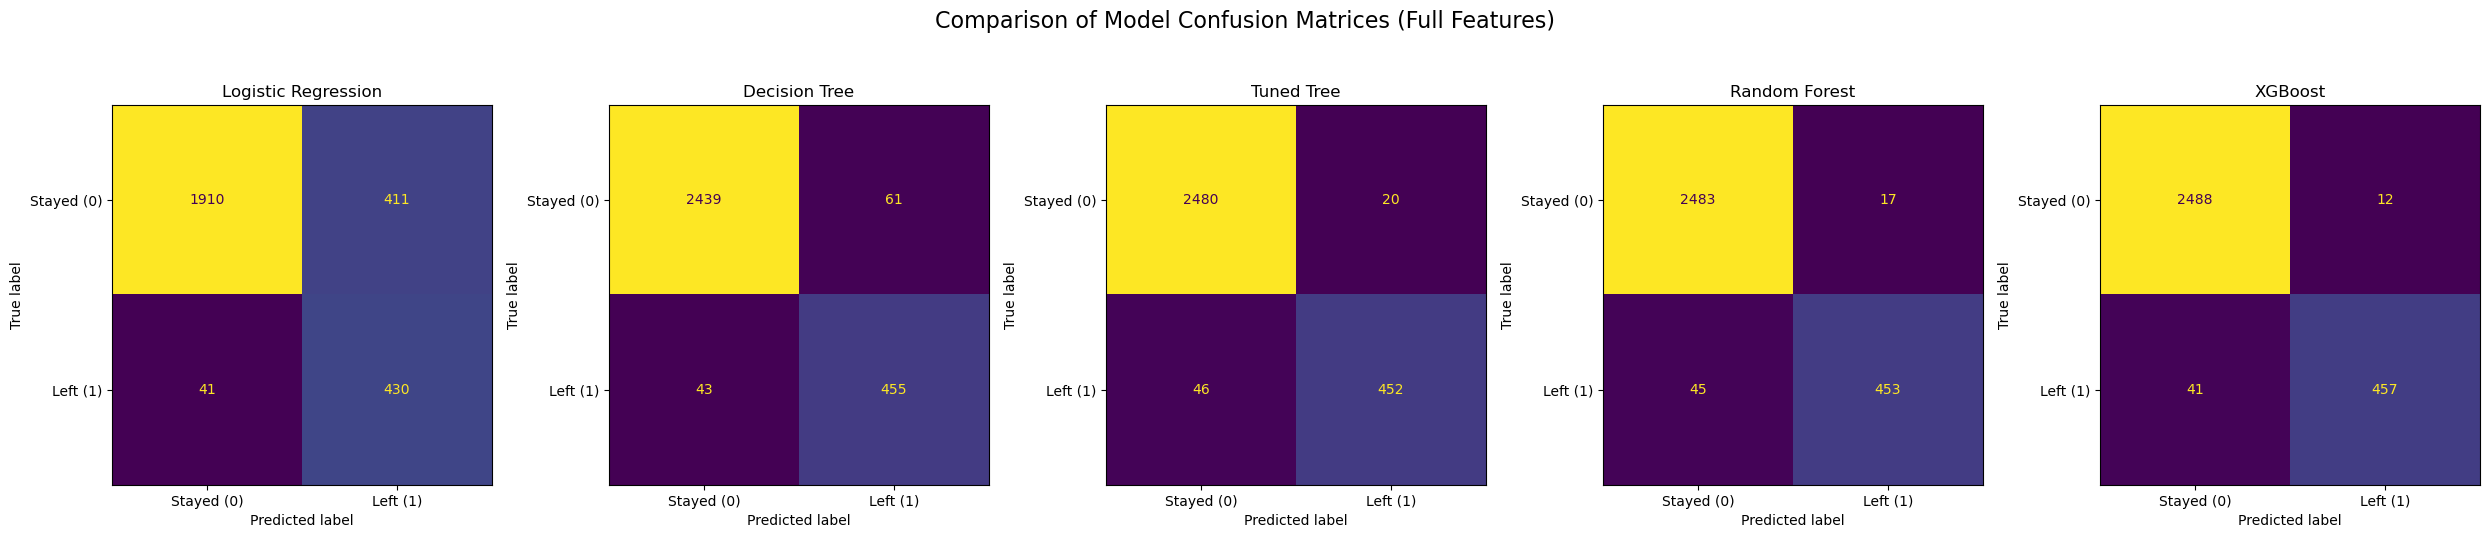

In [416]:
# Confusion matrices
cms = [
    metrics.confusion_matrix(y_lr2_test, y_pred_logreg2, labels=[0, 1]),
    metrics.confusion_matrix(y_dt2_test, y_pred_dt2, labels=[0, 1]),
    metrics.confusion_matrix(y_dt2_test, y_pred_tuned_tree2, labels=[0, 1]),
    metrics.confusion_matrix(y_dt2_test, y_pred_rf_tree2, labels=[0, 1]),
    metrics.confusion_matrix(y_dt2_test, y_pred_xgb2, labels=[0, 1])
]

# Titles
titles = ['Logistic Regression', 'Decision Tree', 'Tuned Tree', 'Random Forest', 'XGBoost']

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Create ConfusionMatrixDisplay object
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    
    # Plot directly on the given ax, and disable the colorbar
    disp.plot(ax=ax, values_format='', colorbar=False)
    
    ax.set_title(titles[i], fontsize=12)
    
fig.suptitle('Comparison of Model Confusion Matrices (Full Features)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [417]:
models = ['Logistic Regression', 'Decision Tree', 'Tuned Tree', 'Random Forest', 'XGBoost']

# predictions
preds = [y_pred_logreg2, y_pred_dt2, y_pred_tuned_tree2, y_pred_rf_tree2, y_pred_xgb2]

# corresponding test sets
y_tests = [y_lr2_test, y_dt2_test, y_dt2_test, y_dt2_test, y_dt2_test]

# predicted probabilities for AUC (positive class)
probas = [y_pred_logreg2_proba, y_pred_dt2_proba, y_pred_tuned_tree2_proba, y_pred_rf_tree2_proba, y_pred_xgb2_proba]


In [418]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_list = []

for i in range(len(models)):
    y_true_i = y_tests[i]
    y_pred_i = preds[i]
    y_proba_i = probas[i]
    
    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    auc = roc_auc_score(y_true_i, y_proba_i)
    
    metrics_list.append({
        'Model': models[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)


                 Model  Accuracy  Precision  Recall  F1 Score   AUC
0  Logistic Regression     0.838      0.511   0.913     0.655 0.894
1        Decision Tree     0.965      0.882   0.914     0.897 0.945
2           Tuned Tree     0.978      0.958   0.908     0.932 0.979
3        Random Forest     0.979      0.964   0.910     0.936 0.984
4              XGBoost     0.982      0.974   0.918     0.945 0.986


##### Overworked (`satisfaction_level`, `last_evaluation`, `number_project`, `average_monthly_hours` (`overworked`) > 175, `time_spend_company`, `promotion_last_5years`,` salary` and `department`) 

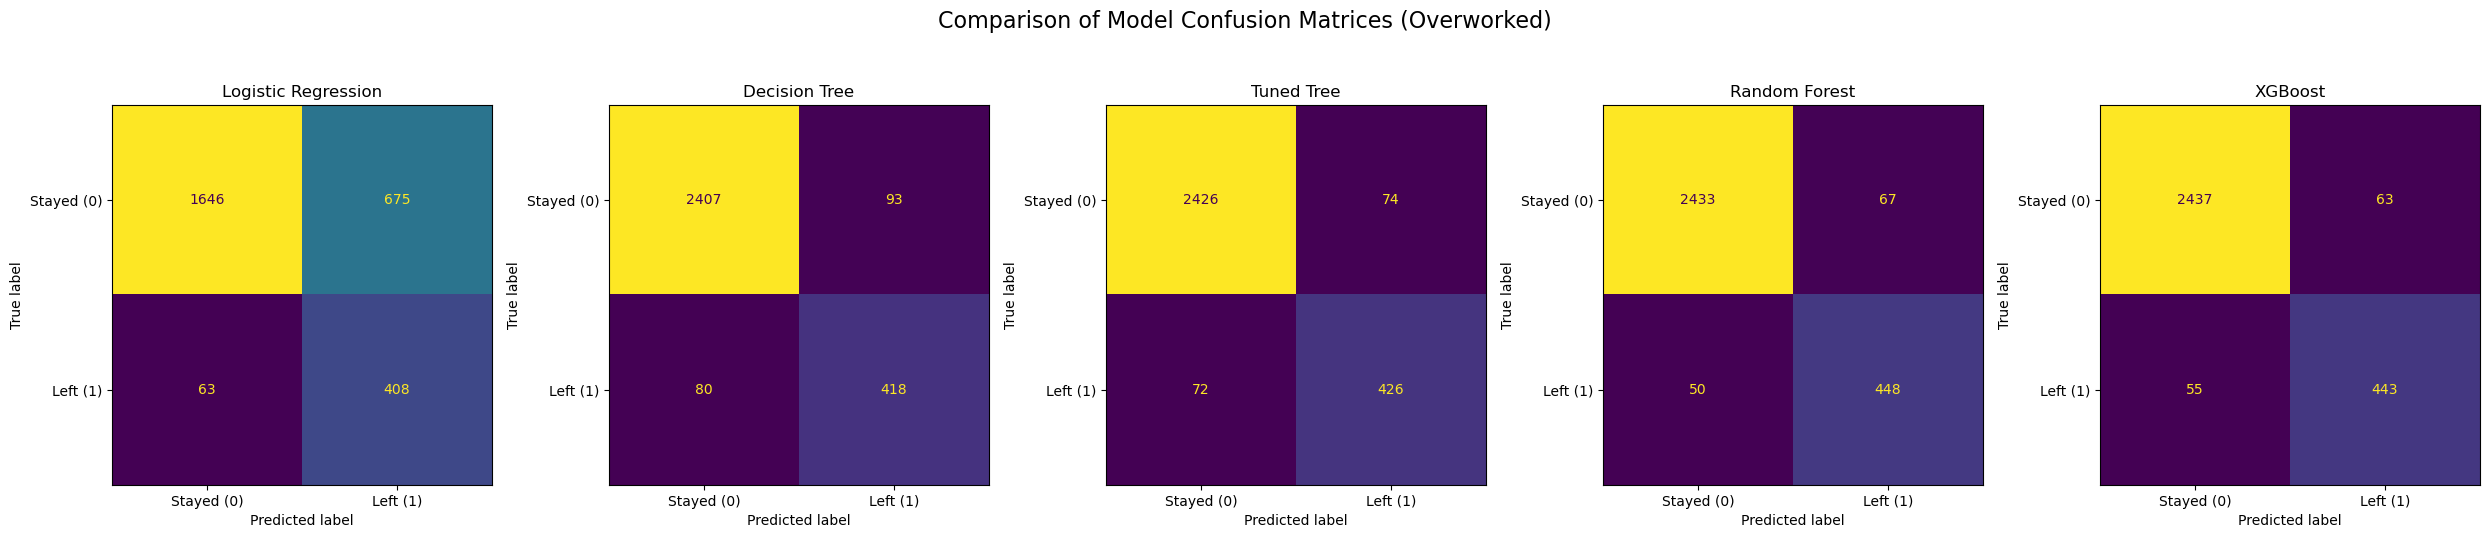

In [419]:
# Confusion matrices
cms = [
    metrics.confusion_matrix(y_lr3_test, y_pred_logreg3, labels=[0, 1]),
    metrics.confusion_matrix(y_dt3_test, y_pred_dt3, labels=[0, 1]),
    metrics.confusion_matrix(y_dt3_test, y_pred_tuned_tree3, labels=[0, 1]),
    metrics.confusion_matrix(y_dt3_test, y_pred_rf_tree3, labels=[0, 1]),
    metrics.confusion_matrix(y_dt3_test, y_pred_xgb3, labels=[0, 1])
]

# Titles
titles = ['Logistic Regression', 'Decision Tree', 'Tuned Tree', 'Random Forest', 'XGBoost']

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Create ConfusionMatrixDisplay object
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    
    # Plot directly on the given ax, and disable the colorbar
    disp.plot(ax=ax, values_format='', colorbar=False)
    
    ax.set_title(titles[i], fontsize=12)
    
fig.suptitle('Comparison of Model Confusion Matrices (Overworked)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [420]:
models = ['Logistic Regression', 'Decision Tree', 'Tuned Tree', 'Random Forest', 'XGBoost']

# predictions
preds = [y_pred_logreg3, y_pred_dt3, y_pred_tuned_tree3, y_pred_rf_tree3, y_pred_xgb3]

# corresponding test sets
y_tests = [y_lr3_test, y_dt3_test, y_dt3_test, y_dt3_test, y_dt3_test]

# predicted probabilities for AUC (positive class)
probas = [y_pred_logreg3_proba, y_pred_dt3_proba, y_pred_tuned_tree3_proba, y_pred_rf_tree3_proba, y_pred_xgb3_proba]


In [421]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_list = []

for i in range(len(models)):
    y_true_i = y_tests[i]
    y_pred_i = preds[i]
    y_proba_i = probas[i]
    
    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    auc = roc_auc_score(y_true_i, y_proba_i)
    
    metrics_list.append({
        'Model': models[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)


                 Model  Accuracy  Precision  Recall  F1 Score   AUC
0  Logistic Regression     0.736      0.377   0.866     0.525 0.816
1        Decision Tree     0.942      0.818   0.839     0.829 0.906
2           Tuned Tree     0.951      0.852   0.855     0.854 0.961
3        Random Forest     0.961      0.870   0.900     0.885 0.968
4              XGBoost     0.961      0.875   0.890     0.882 0.974


#### Model Performance Across Datasets

##### Logistic Regression

In [422]:
datasets = ['Limited', 'Full', 'Overworked']

y_tests = [y_lr1_test, y_lr2_test, y_lr3_test]

y_preds = [y_pred_logreg1, y_pred_logreg2, y_pred_logreg3]

y_probas = [y_pred_logreg1_proba, y_pred_logreg2_proba, y_pred_logreg3_proba]

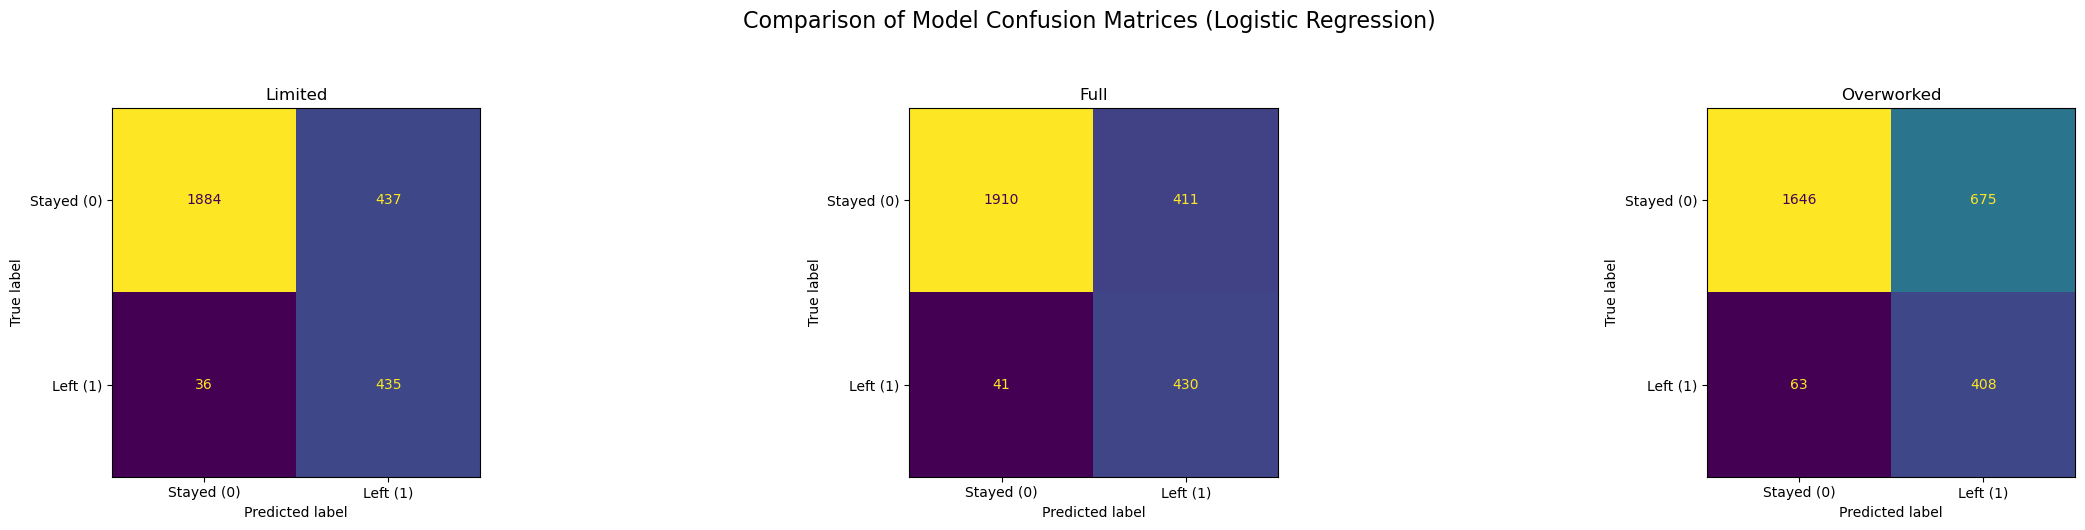

In [423]:
cms = [metrics.confusion_matrix(y_tests[i], y_preds[i], labels=[0,1]) for i in range(len(datasets))]

fig, axes = plt.subplots(1, 3, figsize=(25, 5))  # 1 row, 5 columns

for i, ax in enumerate(axes):
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    disp.plot(ax=ax, values_format='', colorbar=False)
    ax.set_title(datasets[i], fontsize=12)

fig.suptitle('Comparison of Model Confusion Matrices (Logistic Regression)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [424]:
metrics_list = []

for i in range(len(datasets)):
    y_true_i = y_tests[i]
    y_pred_i = y_preds[i]
    y_proba_i = y_probas[i]

    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    
    # handle 1D or 2D probability arrays
    if y_proba_i.ndim == 2:
        auc = roc_auc_score(y_true_i, y_proba_i[:,1])
    else:
        auc = roc_auc_score(y_true_i, y_proba_i)

    metrics_list.append({
        'Dataset': datasets[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

      Dataset  Accuracy  Precision  Recall  F1 Score   AUC
0     Limited     0.831      0.499   0.924     0.648 0.884
1        Full     0.838      0.511   0.913     0.655 0.894
2  Overworked     0.736      0.377   0.866     0.525 0.816


##### Decision Tree

In [425]:
datasets = ['Limited', 'Full', 'Overworked']

y_tests = [y_dt1_test, y_dt2_test, y_dt3_test]

y_preds = [y_pred_dt1, y_pred_dt2, y_pred_dt3]

y_probas = [y_pred_dt1_proba, y_pred_dt2_proba, y_pred_dt3_proba]

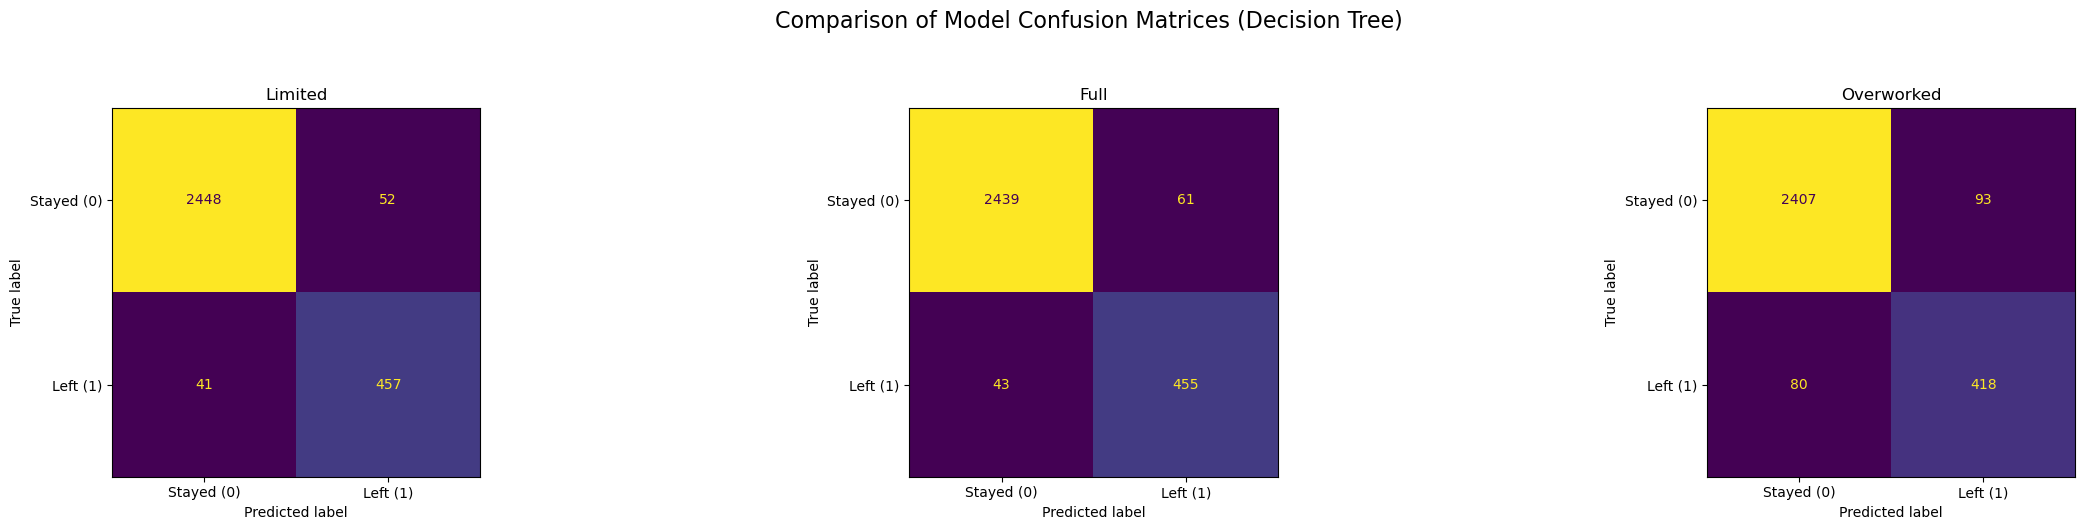

In [426]:
cms = [metrics.confusion_matrix(y_tests[i], y_preds[i], labels=[0,1]) for i in range(len(datasets))]

fig, axes = plt.subplots(1, 3, figsize=(25, 5))  # 1 row, 5 columns

for i, ax in enumerate(axes):
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    disp.plot(ax=ax, values_format='', colorbar=False)
    ax.set_title(datasets[i], fontsize=12)
    
fig.suptitle('Comparison of Model Confusion Matrices (Decision Tree)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [427]:
metrics_list = []

for i in range(len(datasets)):
    y_true_i = y_tests[i]
    y_pred_i = y_preds[i]
    y_proba_i = y_probas[i]

    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    
    # handle 1D or 2D probability arrays
    if y_proba_i.ndim == 2:
        auc = roc_auc_score(y_true_i, y_proba_i[:,1])
    else:
        auc = roc_auc_score(y_true_i, y_proba_i)

    metrics_list.append({
        'Dataset': datasets[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

      Dataset  Accuracy  Precision  Recall  F1 Score   AUC
0     Limited     0.969      0.898   0.918     0.908 0.948
1        Full     0.965      0.882   0.914     0.897 0.945
2  Overworked     0.942      0.818   0.839     0.829 0.906


##### Tuned Decision Tree

In [428]:
datasets = ['Limited', 'Full', 'Overworked']

y_tests = [y_dt1_test, y_dt2_test, y_dt3_test]

y_preds = [y_pred_tuned_tree1, y_pred_tuned_tree2, y_pred_tuned_tree3]

y_probas = [y_pred_tuned_tree1_proba, y_pred_tuned_tree2_proba, y_pred_tuned_tree3_proba]

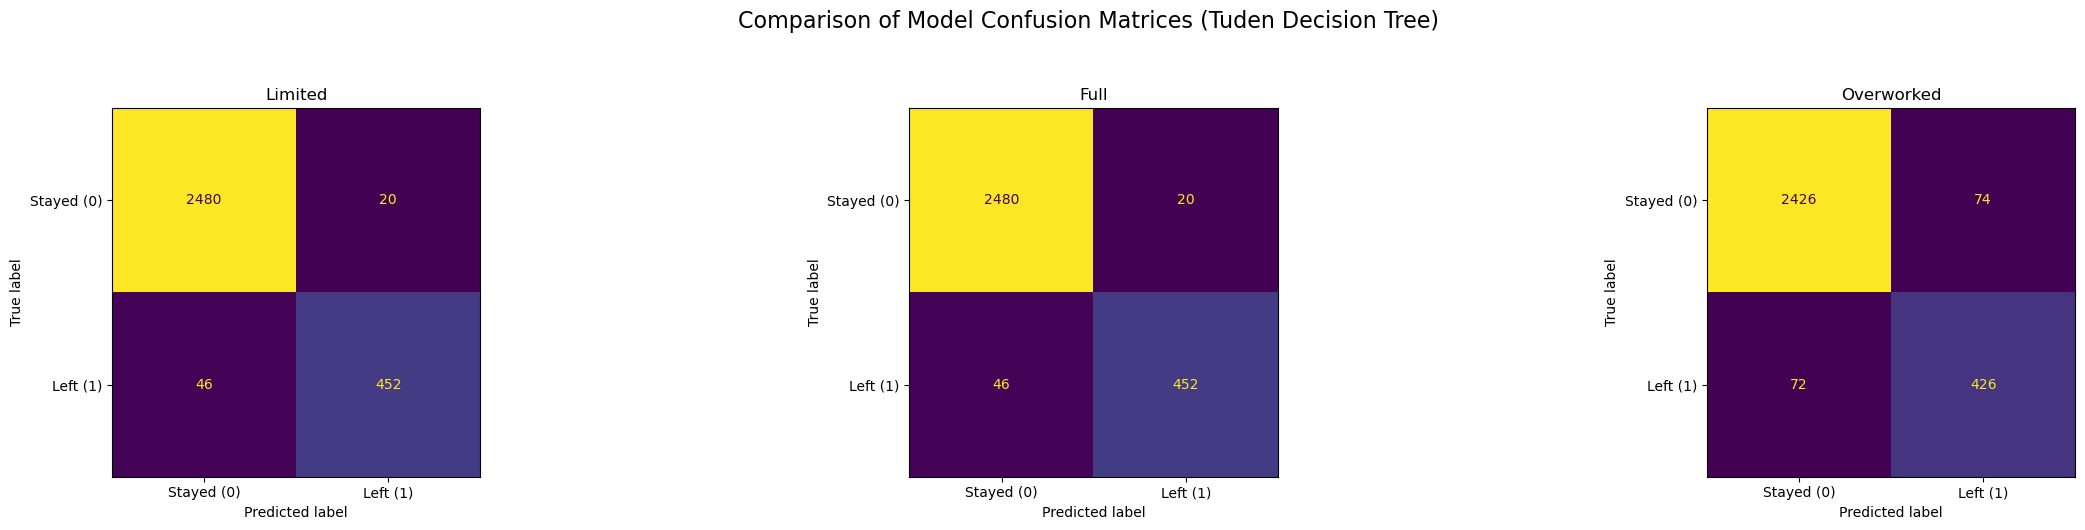

In [429]:
cms = [metrics.confusion_matrix(y_tests[i], y_preds[i], labels=[0,1]) for i in range(len(datasets))]

fig, axes = plt.subplots(1, 3, figsize=(25, 5))  # 1 row, 5 columns

for i, ax in enumerate(axes):
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    disp.plot(ax=ax, values_format='', colorbar=False)
    ax.set_title(datasets[i], fontsize=12)

fig.suptitle('Comparison of Model Confusion Matrices (Tuden Decision Tree)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [430]:
metrics_list = []

for i in range(len(datasets)):
    y_true_i = y_tests[i]
    y_pred_i = y_preds[i]
    y_proba_i = y_probas[i]

    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    
    # handle 1D or 2D probability arrays
    if y_proba_i.ndim == 2:
        auc = roc_auc_score(y_true_i, y_proba_i[:,1])
    else:
        auc = roc_auc_score(y_true_i, y_proba_i)

    metrics_list.append({
        'Dataset': datasets[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

      Dataset  Accuracy  Precision  Recall  F1 Score   AUC
0     Limited     0.978      0.958   0.908     0.932 0.979
1        Full     0.978      0.958   0.908     0.932 0.979
2  Overworked     0.951      0.852   0.855     0.854 0.961


##### Random Forest

In [431]:
datasets = ['Limited', 'Full', 'Overworked']

y_tests = [y_dt1_test, y_dt2_test, y_dt3_test]

y_preds = [y_pred_rf_tree1, y_pred_rf_tree2, y_pred_rf_tree3]

y_probas = [y_pred_rf_tree1_proba, y_pred_rf_tree2_proba, y_pred_rf_tree3_proba]

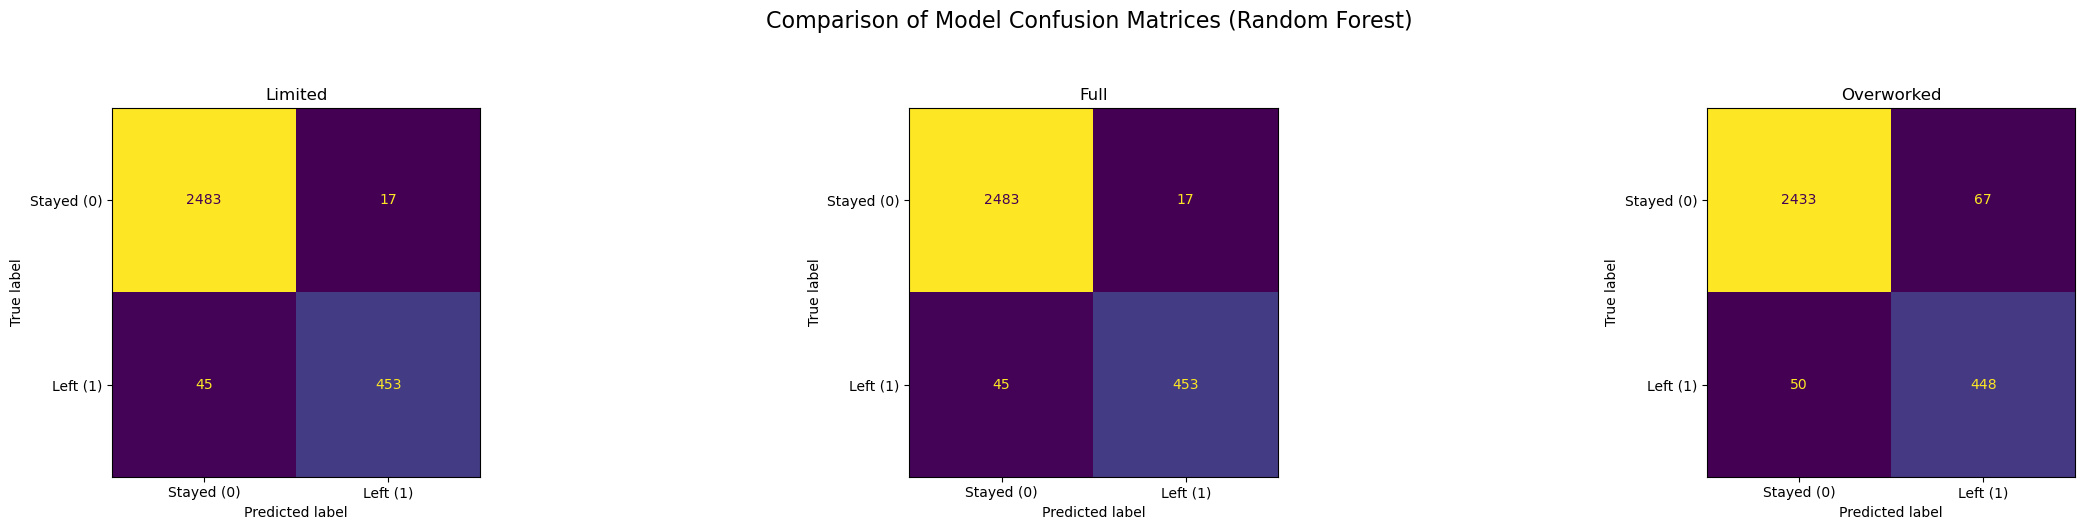

In [432]:
cms = [metrics.confusion_matrix(y_tests[i], y_preds[i], labels=[0,1]) for i in range(len(datasets))]

fig, axes = plt.subplots(1, 3, figsize=(25, 5))  # 1 row, 5 columns

for i, ax in enumerate(axes):
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    disp.plot(ax=ax, values_format='', colorbar=False)
    ax.set_title(datasets[i], fontsize=12)

fig.suptitle('Comparison of Model Confusion Matrices (Random Forest)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [433]:
metrics_list = []

for i in range(len(datasets)):
    y_true_i = y_tests[i]
    y_pred_i = y_preds[i]
    y_proba_i = y_probas[i]

    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    
    # handle 1D or 2D probability arrays
    if y_proba_i.ndim == 2:
        auc = roc_auc_score(y_true_i, y_proba_i[:,1])
    else:
        auc = roc_auc_score(y_true_i, y_proba_i)

    metrics_list.append({
        'Dataset': datasets[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

      Dataset  Accuracy  Precision  Recall  F1 Score   AUC
0     Limited     0.979      0.964   0.910     0.936 0.984
1        Full     0.979      0.964   0.910     0.936 0.984
2  Overworked     0.961      0.870   0.900     0.885 0.968


##### XGBoost

In [434]:
datasets = ['Limited', 'Full', 'Overworked']

y_tests = [y_dt1_test, y_dt2_test, y_dt3_test]

y_preds = [y_pred_xgb1, y_pred_xgb2, y_pred_xgb3]

y_probas = [y_pred_xgb1_proba, y_pred_xgb2_proba, y_pred_xgb3_proba]

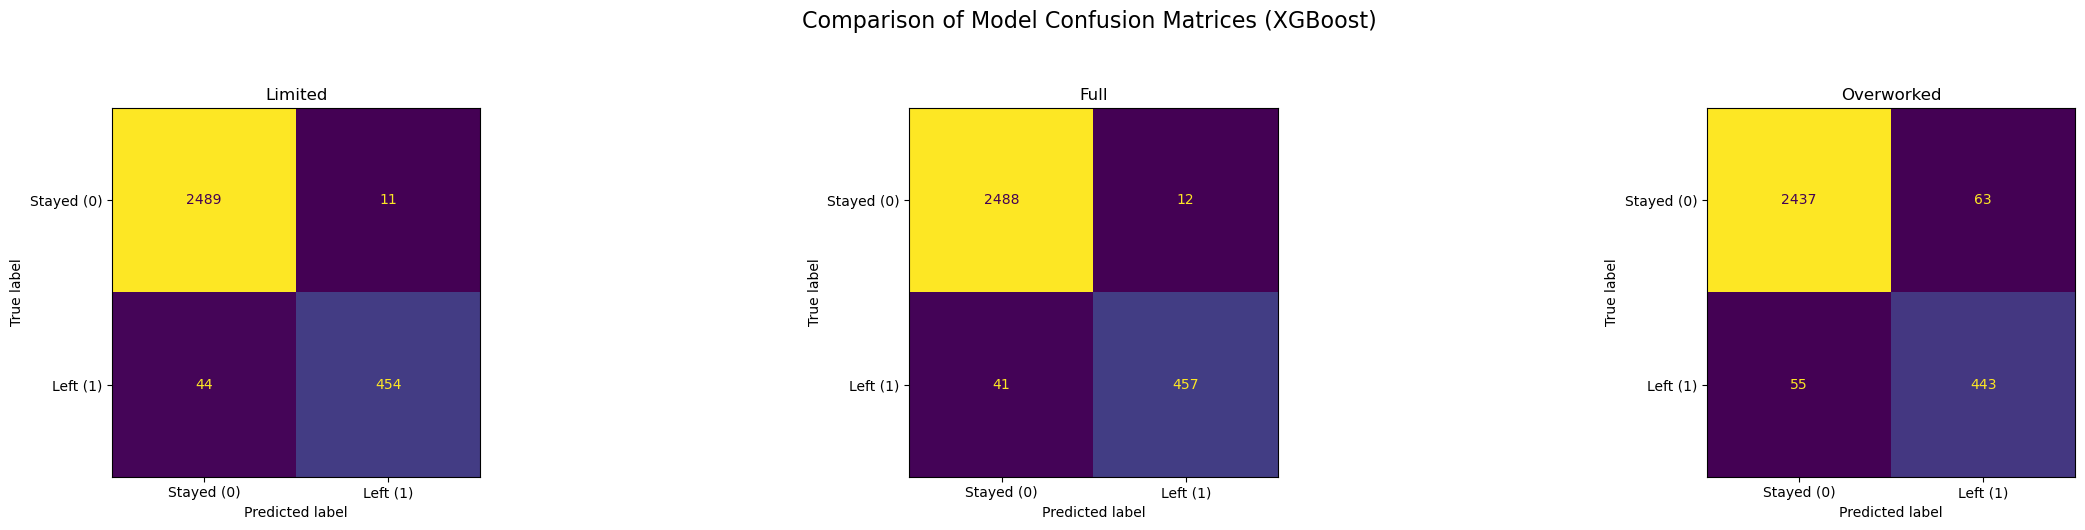

In [435]:
cms = [metrics.confusion_matrix(y_tests[i], y_preds[i], labels=[0,1]) for i in range(len(datasets))]

fig, axes = plt.subplots(1, 3, figsize=(25, 5))  # 1 row, 5 columns

for i, ax in enumerate(axes):
    disp = metrics.ConfusionMatrixDisplay(cms[i], display_labels=['Stayed (0)', 'Left (1)'])
    disp.plot(ax=ax, values_format='', colorbar=False)
    ax.set_title(datasets[i], fontsize=12)
    
fig.suptitle('Comparison of Model Confusion Matrices (XGBoost)', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

In [436]:
metrics_list = []

for i in range(len(datasets)):
    y_true_i = y_tests[i]
    y_pred_i = y_preds[i]
    y_proba_i = y_probas[i]

    accuracy = accuracy_score(y_true_i, y_pred_i)
    precision = precision_score(y_true_i, y_pred_i)
    recall = recall_score(y_true_i, y_pred_i)
    f1 = f1_score(y_true_i, y_pred_i)
    
    # handle 1D or 2D probability arrays
    if y_proba_i.ndim == 2:
        auc = roc_auc_score(y_true_i, y_proba_i[:,1])
    else:
        auc = roc_auc_score(y_true_i, y_proba_i)

    metrics_list.append({
        'Dataset': datasets[i],
        'Accuracy': round(accuracy,3),
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'F1 Score': round(f1,3),
        'AUC': round(auc,3)
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

      Dataset  Accuracy  Precision  Recall  F1 Score   AUC
0     Limited     0.982      0.976   0.912     0.943 0.986
1        Full     0.982      0.974   0.918     0.945 0.986
2  Overworked     0.961      0.875   0.890     0.882 0.974


#### Feature Importance Comparison

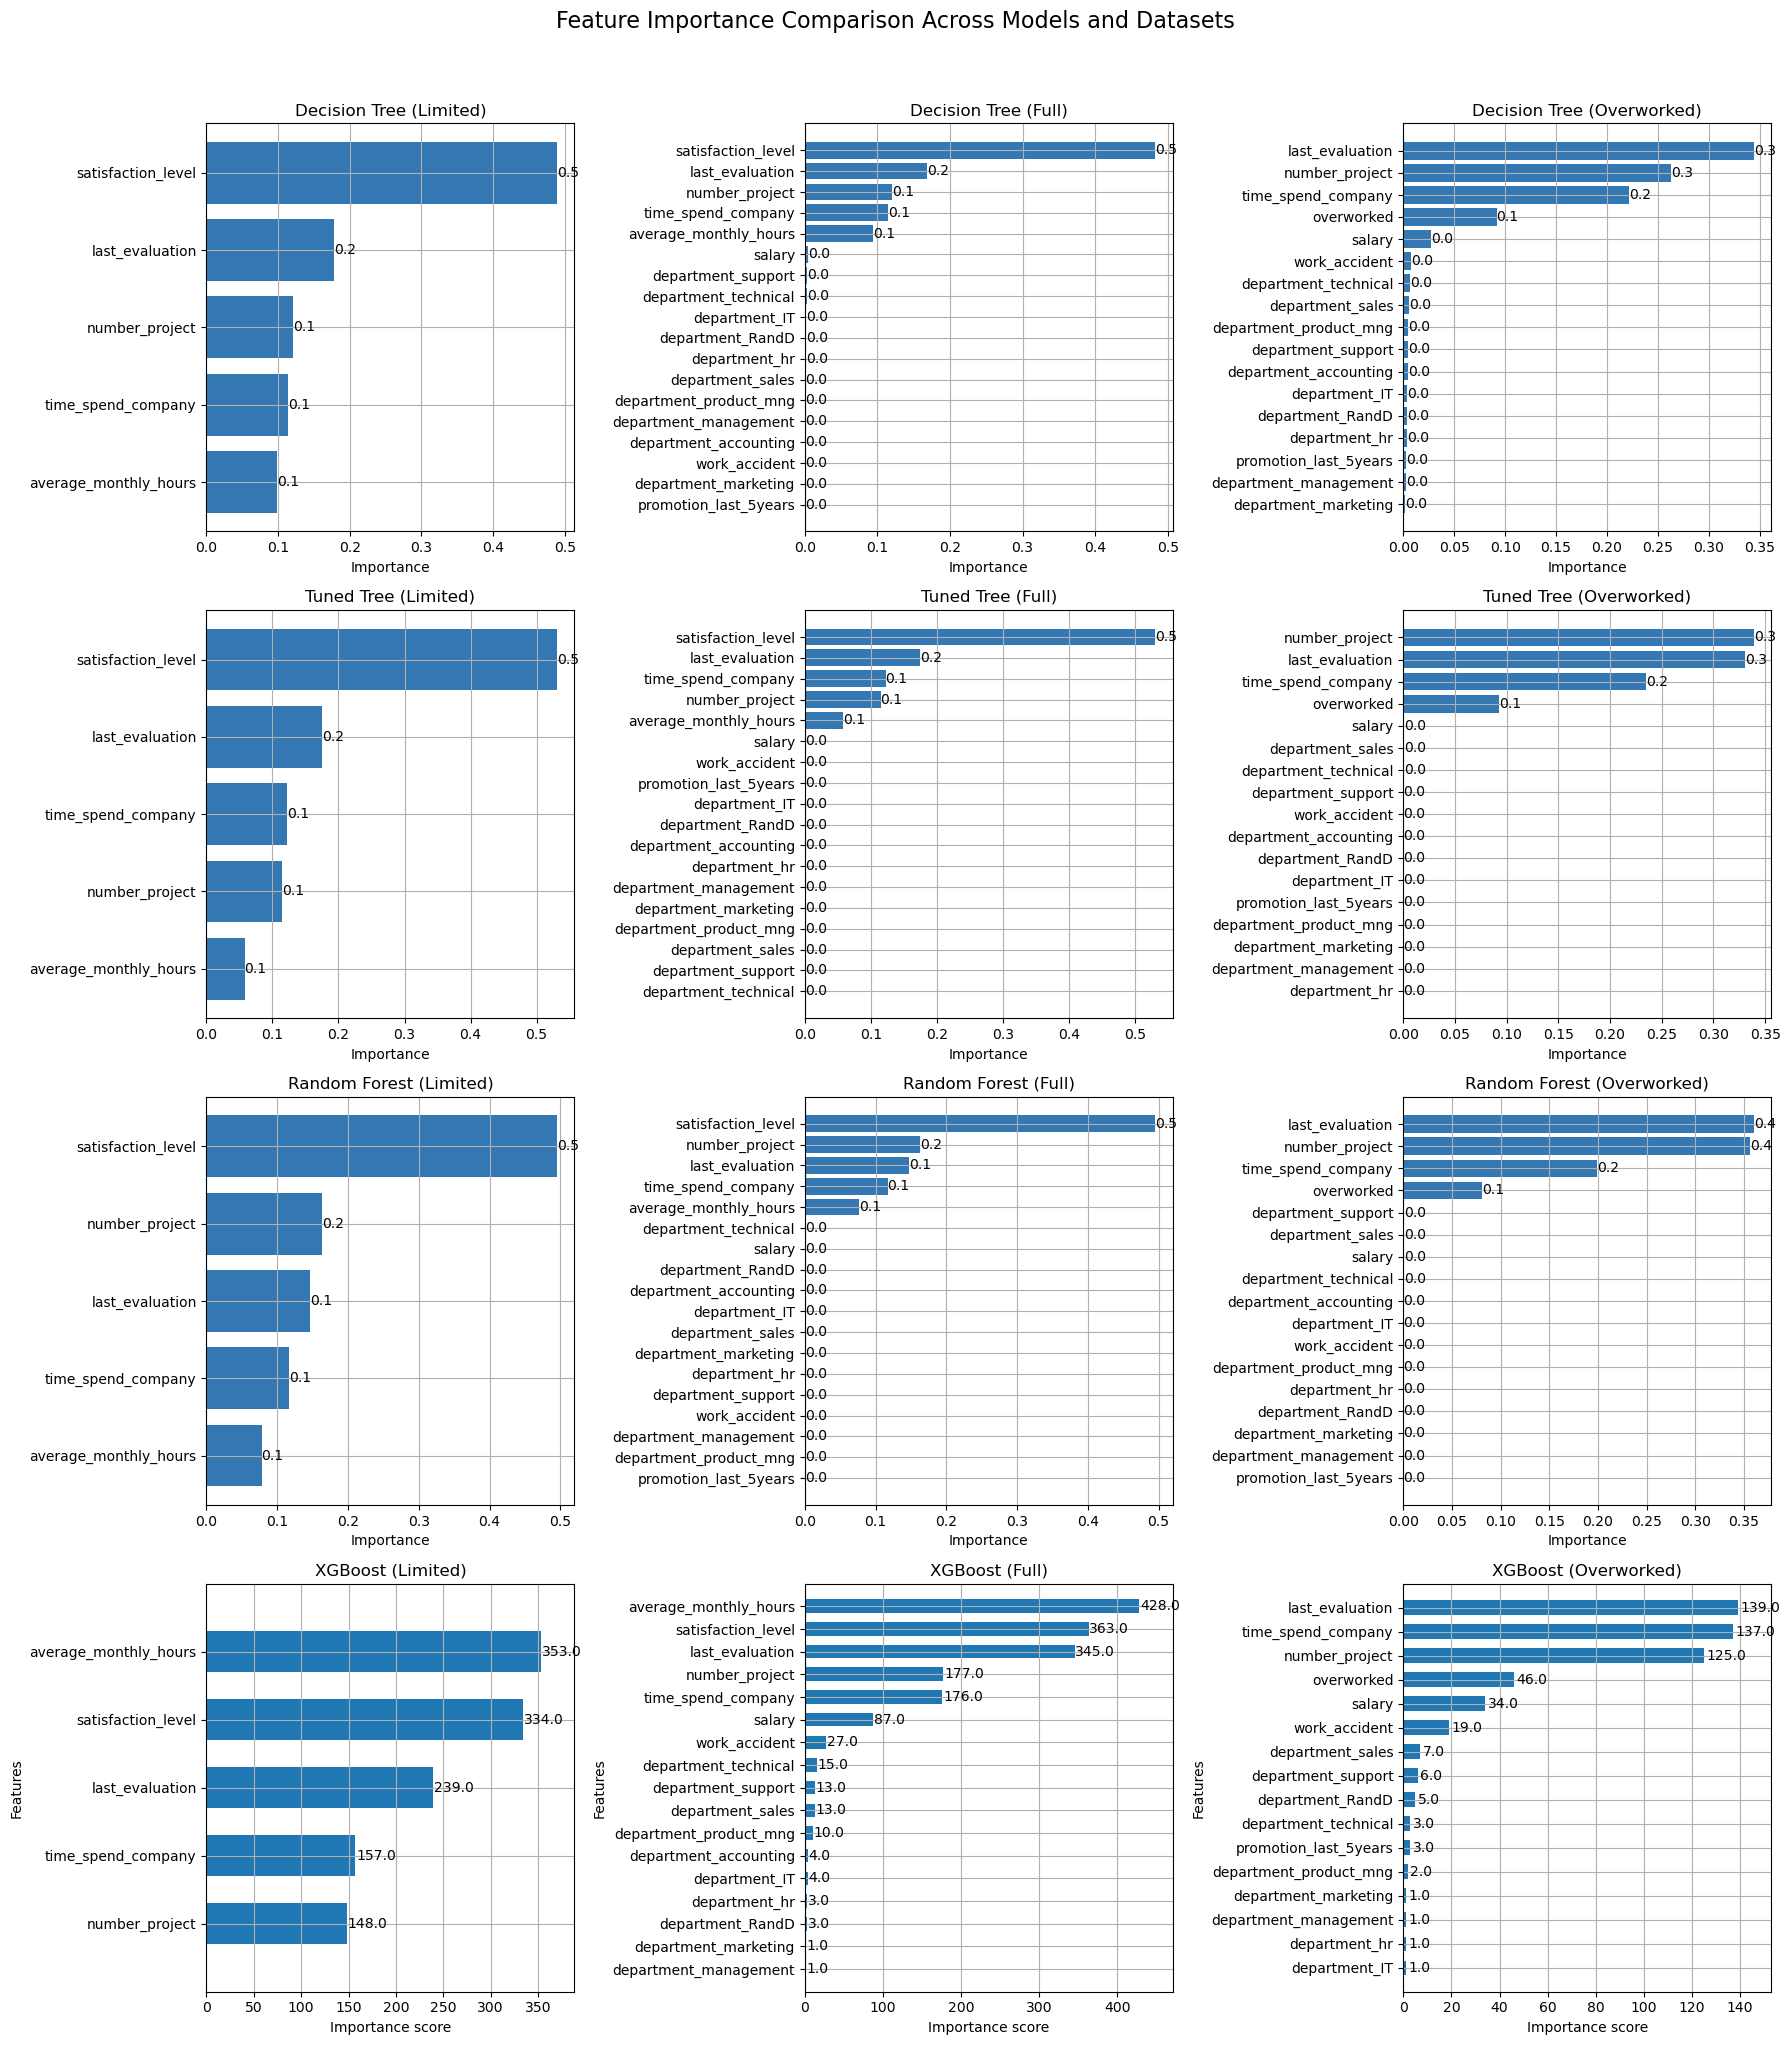

In [513]:
tree_models = ['Decision Tree', 'Tuned Tree', 'Random Forest']
datasets = ['Limited', 'Full', 'Overworked']

fi_tree = [fi_dtdf1, fi_dtdf2, fi_dtdf3]       # Decision Tree
fi_tuned = [fi_tdtdf1, fi_tdtdf2, fi_tdtdf3]   # Tuned Tree
fi_rf = [fi_rfdf1, fi_rfdf2, fi_rfdf3]         # Random Forest

# XGBoost models
xgb_models = [xgb1_grid, xgb2_grid, xgb3_grid]

fig, axes = plt.subplots(4, 3, figsize=(18, 20), sharey=False)

# Function to plot dataframe-based feature importance
def plot_fi_df(ax, fi_df, title):
    fi_sorted = fi_df.sort_values('Importance', ascending=False)
    bars = ax.barh(fi_sorted['Feature'], fi_sorted['Importance'], color='#3377b3')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Importance')
    ax.invert_yaxis()
    ax.grid(True, linestyle='-', alpha=1)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{round(width, 1)}',
                va = 'center', ha = 'left')

for col in range(3):
    # Row 0: Decision Tree
    plot_fi_df(axes[0, col], fi_tree[col], f'Decision Tree ({datasets[col]})')
    
    # Row 1: Tuned Tree
    plot_fi_df(axes[1, col], fi_tuned[col], f'Tuned Tree ({datasets[col]})')
    
    # Row 2: Random Forest
    plot_fi_df(axes[2, col], fi_rf[col], f'Random Forest ({datasets[col]})')
    
    # Row 3: XGBoost
    xgb.plot_importance(xgb_models[col].best_estimator_, ax=axes[3, col], height=0.6, importance_type='weight')
    axes[3, col].set_title(f'XGBoost ({datasets[col]})', fontsize=12)

fig.suptitle('Feature Importance Comparison Across Models and Datasets', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### Model Fit and Overfitting Analysis

In [392]:
def model_fit_summary(model, X_train, y_train, X_test, y_test, Dataframe = 'Dataframe'):
    train_acc = round(model.score(X_train, y_train), 3)
    test_acc = round(model.score(X_test, y_test), 3)
    gap = round(train_acc - test_acc, 3)

    return {'Dataframe': Dataframe, 'Train Accuracy': train_acc, 'Test Accuracy': test_acc, 'Gap': gap}

In [410]:
results = []

results.append(model_fit_summary(decision_tree1, X_dt1_train, y_dt1_train, X_dt1_test, y_dt1_test, "Limited Features"))
results.append(model_fit_summary(decision_tree2, X_dt2_train, y_dt2_train, X_dt2_test, y_dt2_test, "Full Features"))
results.append(model_fit_summary(decision_tree3, X_dt3_train, y_dt3_train, X_dt3_test, y_dt3_test, "Overworked"))

df_summary = pd.DataFrame(results)
average_gap = df_summary['Gap'].mean()
df_summary = df_summary.style.set_caption('<b>Decision Tree<b>') \
.format({'Train Accuracy': '{:.3f}', 'Test Accuracy': '{:.3f}', 'Gap': '{:.3f}'})
display(df_summary)
print('Average gap:', round(average_gap, 3))

Average gap: 0.039


In [409]:
results = []

results.append(model_fit_summary(tree1_grid, X_dt1_train, y_dt1_train, X_dt1_test, y_dt1_test, "Limited Features"))
results.append(model_fit_summary(tree2_grid, X_dt2_train, y_dt2_train, X_dt2_test, y_dt2_test, "Full Features"))
results.append(model_fit_summary(tree3_grid, X_dt3_train, y_dt3_train, X_dt3_test, y_dt3_test, "Overworked"))

df_summary = pd.DataFrame(results)
average_gap = df_summary['Gap'].mean()
df_summary = df_summary.style.set_caption('<b>Tuned Decision Tree<b>') \
.format({'Train Accuracy': '{:.3f}', 'Test Accuracy': '{:.3f}', 'Gap': '{:.3f}'})
display(df_summary)
print('Average gap:', round(average_gap, 3))

Average gap: 0.007


In [411]:
results = []

results.append(model_fit_summary(rf_tree1_grid, X_dt1_train, y_dt1_train, X_dt1_test, y_dt1_test, "Limited Features"))
results.append(model_fit_summary(rf_tree2_grid, X_dt2_train, y_dt2_train, X_dt2_test, y_dt2_test, "Full Features"))
results.append(model_fit_summary(rf_tree3_grid, X_dt3_train, y_dt3_train, X_dt3_test, y_dt3_test, "Overworked"))

df_summary = pd.DataFrame(results)
average_gap = df_summary['Gap'].mean()
df_summary = df_summary.style.set_caption('<b>Random Forest<b>') \
.format({'Train Accuracy': '{:.3f}', 'Test Accuracy': '{:.3f}', 'Gap': '{:.3f}'})
display(df_summary)
print('Average gap:', round(average_gap, 3))

Average gap: 0.004


In [412]:
results = []

results.append(model_fit_summary(xgb1_grid, X_dt1_train, y_dt1_train, X_dt1_test, y_dt1_test, "Limited Features"))
results.append(model_fit_summary(xgb2_grid, X_dt2_train, y_dt2_train, X_dt2_test, y_dt2_test, "Full Features"))
results.append(model_fit_summary(xgb3_grid, X_dt3_train, y_dt3_train, X_dt3_test, y_dt3_test, "Overworked"))

df_summary = pd.DataFrame(results)
average_gap = df_summary['Gap'].mean()
df_summary = df_summary.style.set_caption('<b>XGBoost<b>') \
.format({'Train Accuracy': '{:.3f}', 'Test Accuracy': '{:.3f}', 'Gap': '{:.3f}'})
display(df_summary)
print('Average gap:', round(average_gap, 3))

Average gap: 0.005


#### Summary of model results

- **Logistic Regression**: High recall but low precision - the model correctly indenfified most employees who left but also produced lots of false positives.
- **Untuned Decision Treе**: High accuracy and recall, large jump in performance vs Logistic Regression but the model overfitted.
- **Tuned Decision Tree**: The tuning improved the performence of the model and got rid of the overfitting.
- **Random Forest**: Consistent and reliable results across all dataframes. Second highest overall performance. High AUC shows excellent separation between classes.
- **XGBoost**: Highest performance overall. Balanced Precision and Recall. Again has high AUC with excellent separation between classes. However it shows mild signs of overfitting.

##### Feature Importance

From the above comparisons it is evident that the **full-feature dataset** is **redundant**, and including all features sometimes **reduces model performance**. Interestingly, the **overworked dataset** highlights different features and patterns specific to overworked employees, which can be **useful for targeted interventions**.

#### Conclusion and Recommendations

The **Random Forest** model is selected as the **final model** due to its consistency and reliability across all datasets. **XGBoost** is a strong **alternative** but shows mild signs of overfitting. The **Limited Features** dataset is preferred for general modeling, while the **Overworked** dataset supports focused employee analysis.

**Based on the Data Analysis, to retain employees, the following recommendations could be presented to the stakeholders**: 
* **Cap the number of projects** that employees can work on. Optimal workload is around **3–4 projects**, which is linked to higher satisfaction and lower churn rate.
* **Review workloads and overtime expectations** - Either reward employees who consistently work longer hours or prevent overwork through clearer task distribution.
* **Clarify overtime pay and workload expectations**. If policies around compensation or time off are unclear, communicate them explicitly across all departments.
* **Investigate the dissatisfaction among four-year tenured employees**. Consider targeted engagement or promotion opportunities for this group, as they appear at higher risk of leaving.
* **Redefine performance evaluations**. High evaluation scores should not be reserved only for those working 200+ hours per month. Introduce a **proportionate evaluation system** that recognizes efficiency and teamwork, not just total output.
* **Promotion of Career Growth**. Promotions don’t strongly correlate with retention, but **very few promoted employees left**. Introduce **transparent career development plans** and **visible promotion opportunities** to increase motivation and retentio

#### Important disclaimer - The unusual clean clustering in the scatterplots may suggest synthetic or manipulated data.

# **Final Reflections**

At the beginning of this project, I struggled a lot with Python. Everything felt complicated, and I had to look up every small thing. Over time, though, I started getting used to it. I became more comfortable working with data, writing functions, and understanding what the code was actually doing.

At first, I wasn’t excited about machine learning either. During the onlne course I was honestly burned out and not really into it. But as I kept going with this project, I got more interested. Once I started seeing how the models worked and what kind of insights they could bring, it became more engaging.

By the end, I gave the project everything I had. It helped me improve a lot with Python and changed how I see machine learning — I don’t hate it anymore, and I actually find it interesting now. Overall, it was a good project to get into the field and to build both confidence and practical skills.